<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/ML%20ECG%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependencies

2025 march - Gensim library has been updated. So, we neen reconfigure dependencies.

see more informations
https://github.com/Sinaptik-AI/pandas-ai/issues/1251

In [ ]:
!pip install --upgrade gensim
import os
os.kill(os.getpid(), 9)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from gensim.models import Word2Vec

In [2]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis='columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='hist')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('%.1f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Таблица анализа данных, коэффициент корреляции')
    plt.show()

In [3]:
def decision_boundary_plot(X, y, X_train, y_train, clf, feature_indexes, title=None):
    feature1_name, feature2_name = X.columns[feature_indexes]
    X_feature_columns = X.values[:, feature_indexes]
    X_train_feature_columns = X_train[:, feature_indexes]
    clf.fit(X_train_feature_columns, y_train)

    plot_decision_regions(X=X_feature_columns, y=y.values, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)

# Загрузка, очистка и визуализация данных

Пример - медицина - дата сет кардиология:
выгружено и предобработано MIMIC-IV-ECG/ Diagnostic Electrocardiogram Matched Subset v1.0

Столбец **Healthy_Status**: 0 = пациент, 1 - условно здоровый.

https://physionet.org/content/mimic-iv-ecg/1.0/

Декодированы метки времени, добавлен признак Healthy_Status

Полезная ссылка на понимание ЭКГ: https://ecgwaves.com/topic/ecg-normal-p-wave-qrs-complex-st-segment-t-wave-j-point/

Полный датасет ECG_array_arrow_data.csv:

https://drive.google.com/file/d/1-Z2Yvcl7J8ZhdSp-MEqTHfzdrhbSdcdB/view?usp=share_link


In [4]:
# загружаем полный датасет
raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=5000)
raw_table_data.head(10)

subject_id  Count_subj  study_id  cart_id  Healthy_Status eeg_time   \
0    19557662          27  40000017  6848296               0   8:44 AM   
1    18477137          93  40000029  6848296               0   9:54 AM   
2    16598616           3  40000035  6376932               1   9:07 AM   
3    16368287           7  40000079  6214760               1   5:14 PM   
4    18370366           2  40000084  6632385               0   1:52 PM   
5    15606157          55  40000089  6632385               0   2:29 PM   
6    12576058          43  40000115  6852956               1  12:54 PM   
7    14691089           1  40000143  6551957               0  10:01 AM   
8    14144725           7  40000144  6924910               0   7:24 AM   
9    16089780           2  40000152  6919786               0  12:35 PM   

    eeg_date                    report_0  \
0  27.06.2015               Sinus rhythm   
1  27.06.2015               Sinus rhythm   
2  28.06.2015          Sinus tachycardia   
3  15.07.2015               Sinus rhythm   
4  27.09.2015               Sinus rhythm   
5  29.10.2013               Sinus rhythm   
6  23.03.2016               Sinus rhythm   
7  10.12.2016               Sinus rhythm   
8  11.12.2011  Sinus rhythm with PAC(s).   
9  13.12.2011               Sinus rhythm   

                                            report_1  \
0                  Possible right atrial abnormality   
1                  Possible right atrial abnormality   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5                                                NaN   
6                                                NaN   
7                 rSr'(V1) - probable normal variant   
8                                                NaN   
9  Extensive T wave changes may be due to myocard...   

                               report_2  ...                    filtering  \
0                                   NaN  ...  60 Hz notch Baseline filter   
1                                   NaN  ...  60 Hz notch Baseline filter   
2            Normal ECG except for rate  ...  60 Hz notch Baseline filter   
3                            Normal ECG  ...  60 Hz notch Baseline filter   
4                                   NaN  ...              <not specified>   
5                                   NaN  ...              <not specified>   
6                            Normal ECG  ...  60 Hz notch Baseline filter   
7  Low QRS voltages in precordial leads  ...  60 Hz notch Baseline filter   
8                        Borderline ECG  ...  60 Hz notch Baseline filter   
9                                   NaN  ...  60 Hz notch Baseline filter   

  rr_interval p_onset  p_end qrs_onset qrs_end t_end p_axis qrs_axis t_axis  
0         659      40    128       170     258   518     81       77     79  
1         722      40    124       162     246   504     77       75     70  
2         600      40    130       162     244   474     79       72     77  
3         659      40    146       180     254   538     79       66     69  
4         659     368  29999       504     590   868     84       80     77  
5         822     365  29999       499     592   852     26       46     30  
6         952      40    146       198     282   598     24       80     20  
7         923      40    140       188     278   594     26       86     13  
8         952      40    180       196     294   610     59      -17      3  
9        1000      40    156       178     274   584      8      -11     19  

[10 rows x 36 columns]

In [5]:
# Предобрабатываем данные словестных репортов word2vec в числовой вектор

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = raw_table_data[(raw_table_data[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Фиксим имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})
full_df_filtered = full_df_filtered.drop(columns = ['bandwidth', 'filtering'])

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

# Разбиваем столбец с текстовым отчетом на токены
words = [text.split() for text in full_df_filtered['report']]

# Обучаем модель Word2Vec
w2v_model = Word2Vec(words)

# Функция для получения среднего эмбеддинга строки
def get_sentence_embedding(sentence):
    words = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

# Применяем функцию ко всей колонке и переводим каждый вектор в одно число
full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

full_df_filtered.head()

subject_id  Count_subj  study_id  cart_id  eeg_time    eeg_date    report  \
0    19557662          27  40000017  6848296   8:44 AM  27.06.2015  0.013494   
1    18477137          93  40000029  6848296   9:54 AM  27.06.2015  0.013494   
2    16598616           3  40000035  6376932   9:07 AM  28.06.2015  0.035095   
3    16368287           7  40000079  6214760   5:14 PM  15.07.2015  0.025316   
6    12576058          43  40000115  6852956  12:54 PM  23.03.2016  0.025316   

   rr_interval  p_onset  p_end  qrs_onset  qrs_end  t_end  p_axis  qrs_axis  \
0          659       40    128        170      258    518      81        77   
1          722       40    124        162      246    504      77        75   
2          600       40    130        162      244    474      79        72   
3          659       40    146        180      254    538      79        66   
6          952       40    146        198      282    598      24        80   

   t_axis  Healthy_Status  
0      79               0  
1      70               0  
2      77               1  
3      69               1  
6      20               1

In [6]:
# make new dataset from old columns
table_data = full_df_filtered[['report','rr_interval','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status']].copy()
table_data.head()

report  rr_interval  p_end  qrs_onset  qrs_end  t_end  p_axis  qrs_axis  \
0  0.013494          659    128        170      258    518      81        77   
1  0.013494          722    124        162      246    504      77        75   
2  0.035095          600    130        162      244    474      79        72   
3  0.025316          659    146        180      254    538      79        66   
6  0.025316          952    146        198      282    598      24        80   

   t_axis  Healthy_Status  
0      79               0  
1      70               0  
2      77               1  
3      69               1  
6      20               1

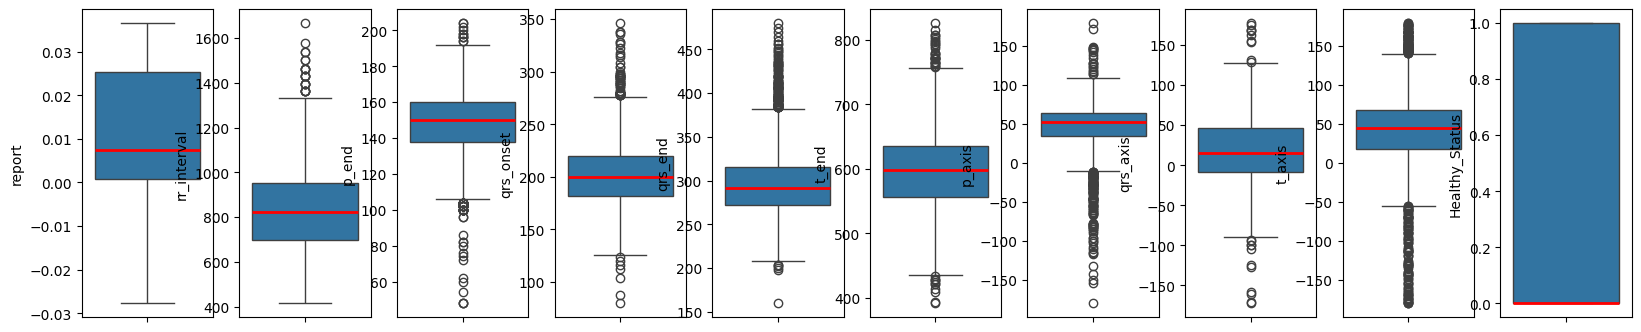

In [7]:
n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data, medianprops={"color": "r", "linewidth": 2})

In [8]:
# удаляем аномалии из данных (убрать все значения более 5000)
#table_data = table_data.drop(table_data[table_data['qrs_axis'] > 5000].index)
for i, v in enumerate(table_data):
  table_data = table_data.drop(table_data[table_data.iloc[:,i] > 10000].index)

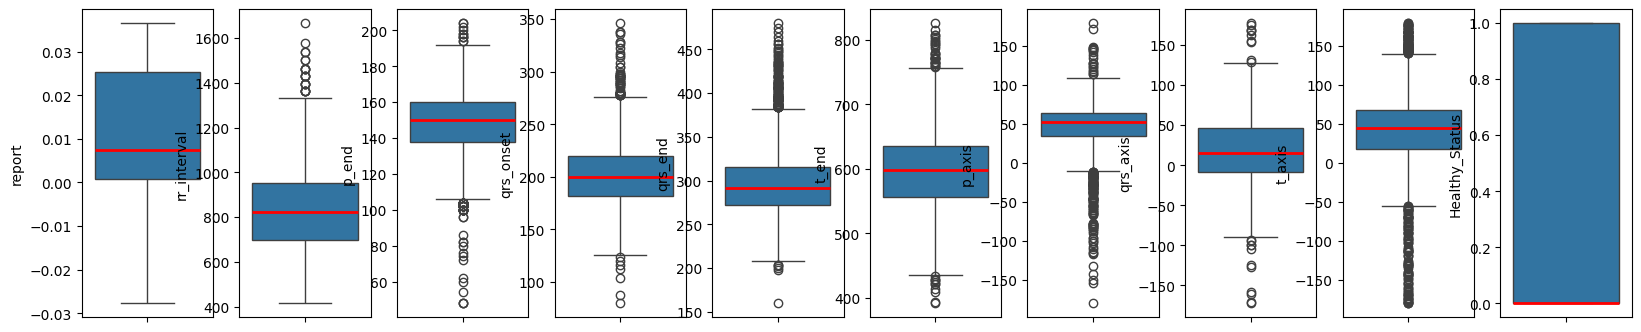

In [9]:
n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data,
                medianprops={"color": "r", "linewidth": 2})
    plt.tight_layout

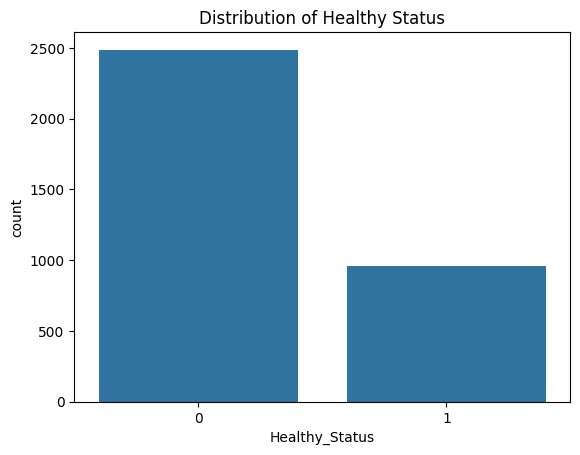

In [10]:
sns.countplot(data=table_data, x="Healthy_Status")
plt.title("Distribution of Healthy Status")
plt.show()

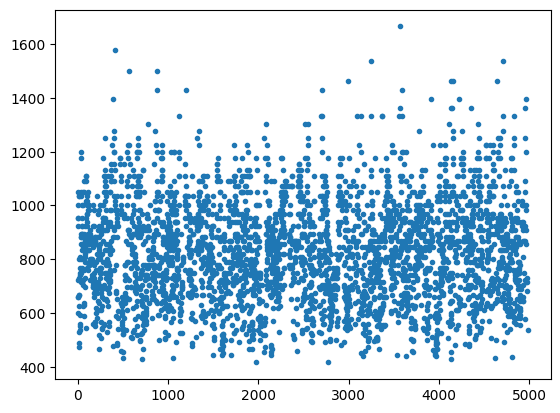

In [11]:
#example view
plt.plot(table_data['rr_interval'],'.')

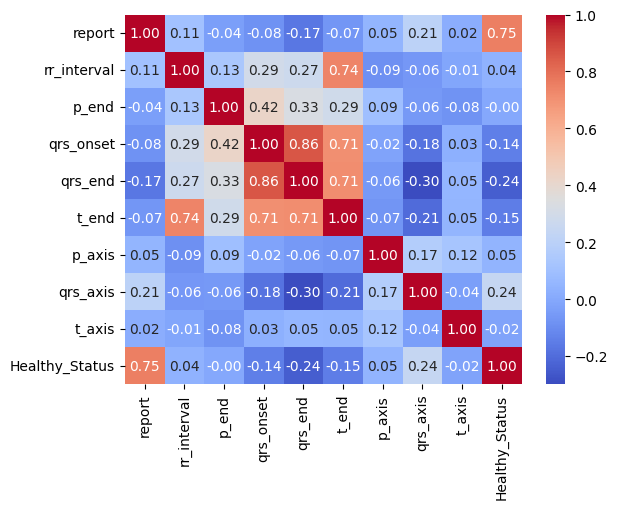

In [12]:
sns.heatmap(table_data.corr(),annot=True,fmt="0.2f",cmap="coolwarm")
plt.show()

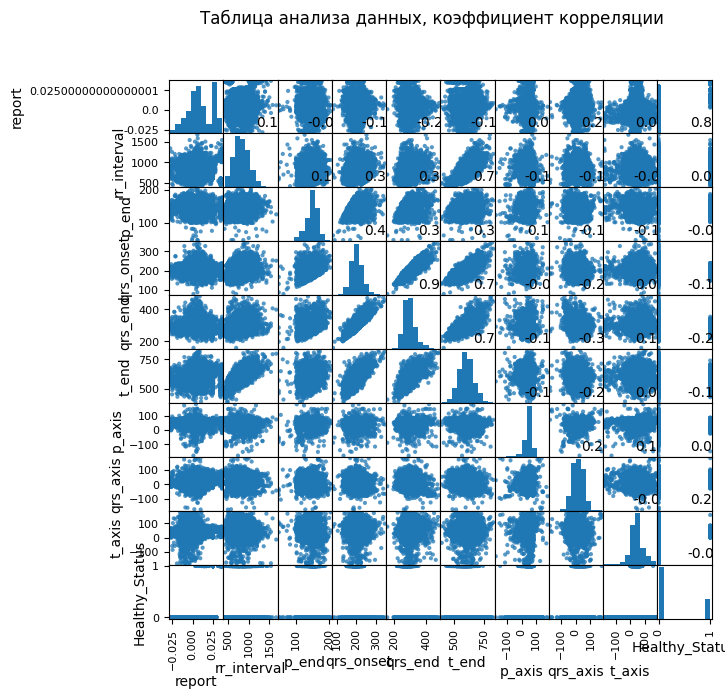

In [13]:
plotScatterMatrix(table_data, 7, 10)

<Axes: xlabel='rr_interval', ylabel='p_axis'>

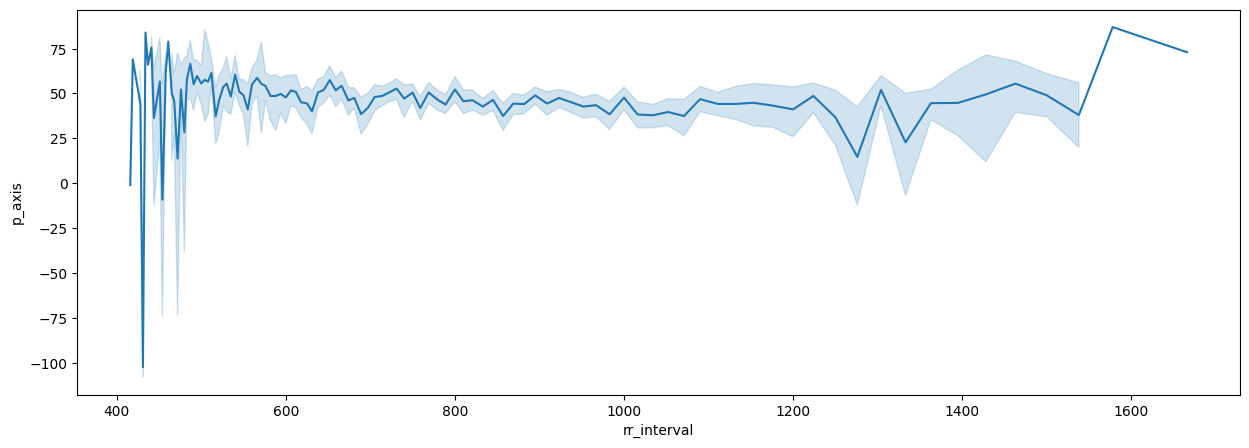

In [14]:
fig,ax = plt.subplots(figsize=(15,5))
#sns.lineplot(x='age',y='debtinc',data=table_data,ax=ax)
sns.lineplot(x='rr_interval',y='p_axis',data=table_data,ax=ax)

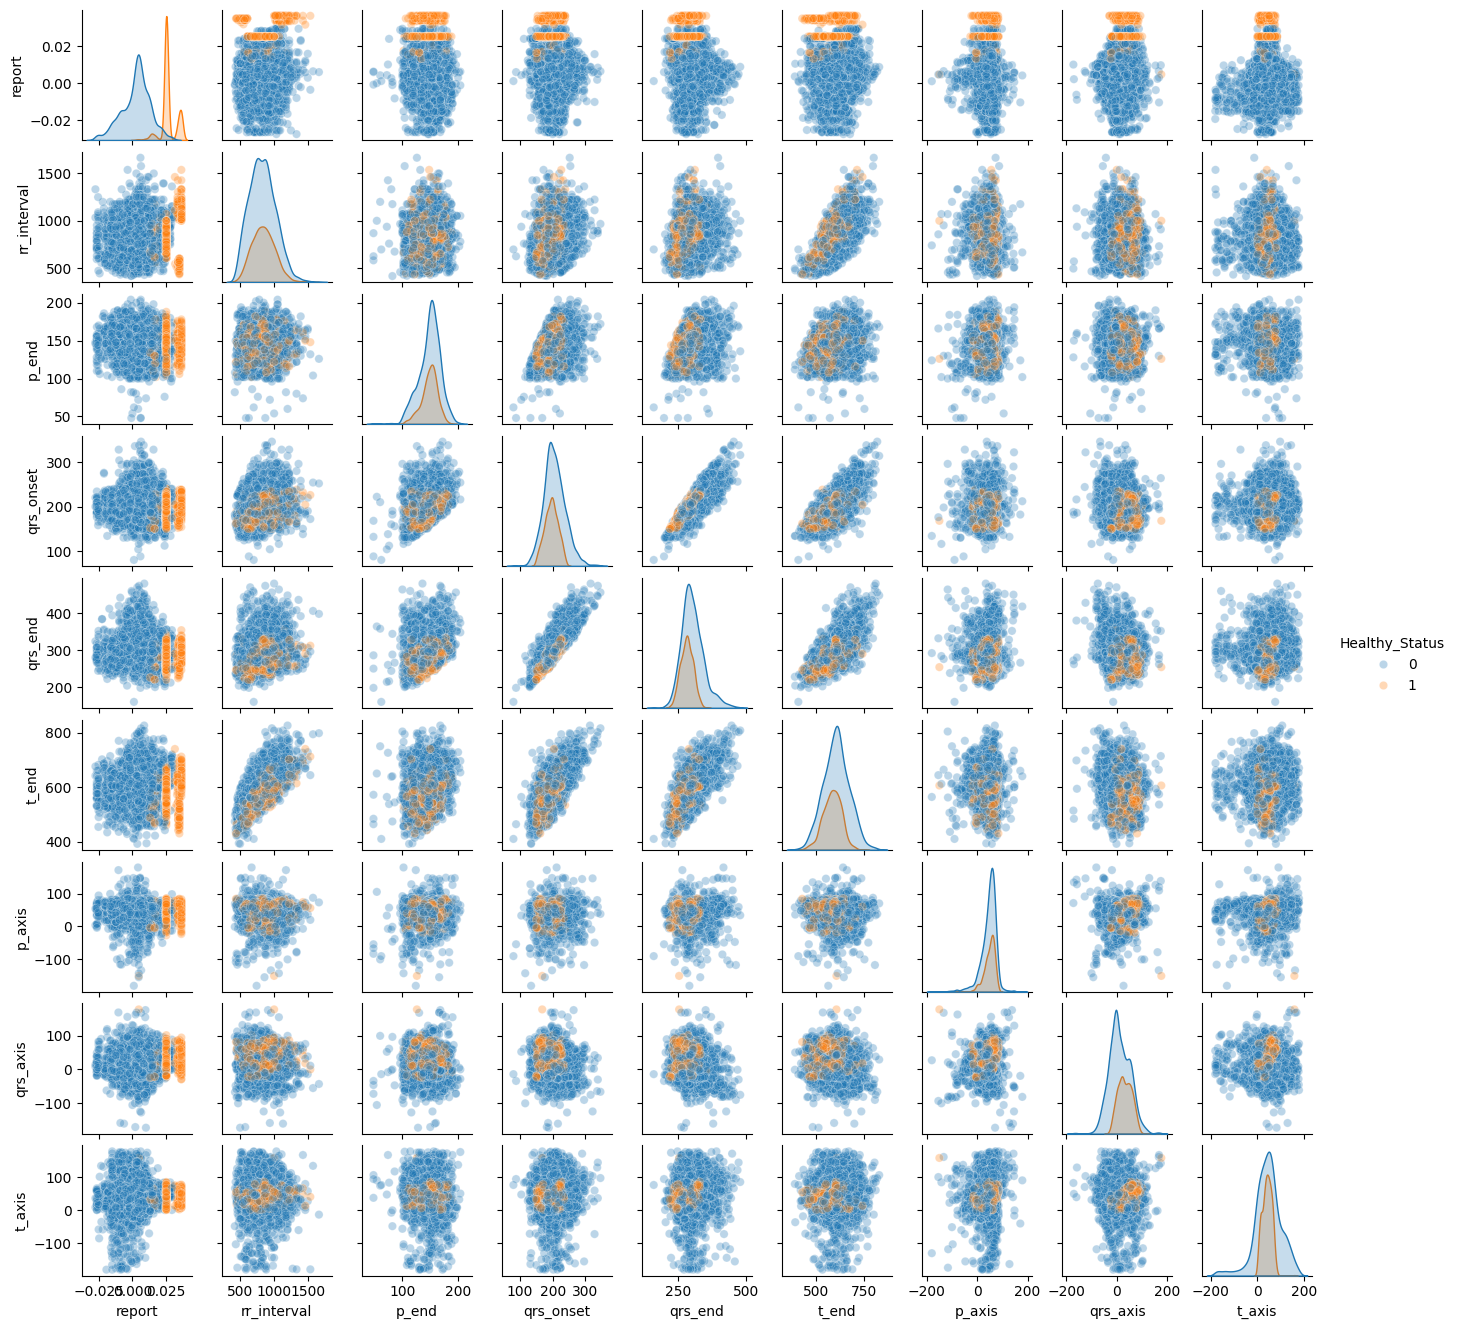

In [15]:
#labels = pd.DataFrame(table_data['Healthy_Status'])
sns.pairplot(table_data, hue = "Healthy_Status",
             height=1.5,
             plot_kws=dict(alpha=0.3))

<Axes: xlabel='rr_interval', ylabel='qrs_end'>

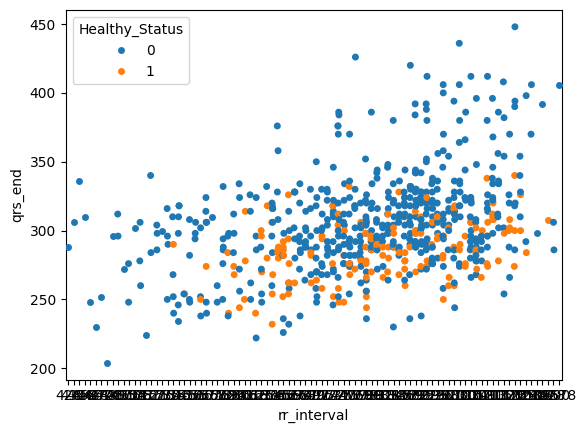

In [ ]:
sns.stripplot(x=table_data['rr_interval'],y=table_data['qrs_end'],
              hue=table_data['Healthy_Status'],jitter=True)

<Axes: xlabel='rr_interval'>

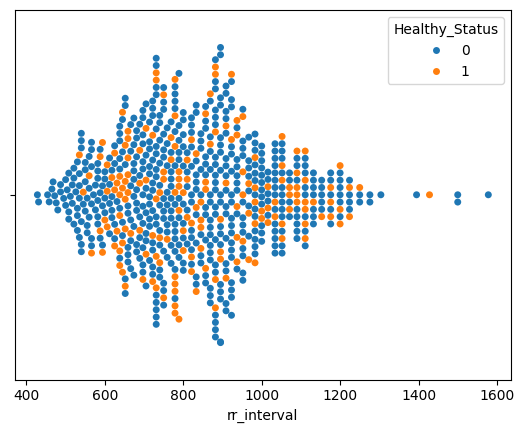

In [ ]:
sns.swarmplot(data=table_data, x="rr_interval", hue="Healthy_Status")

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-09-29 16:45:00,950 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-09-29 16:45:00,964 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


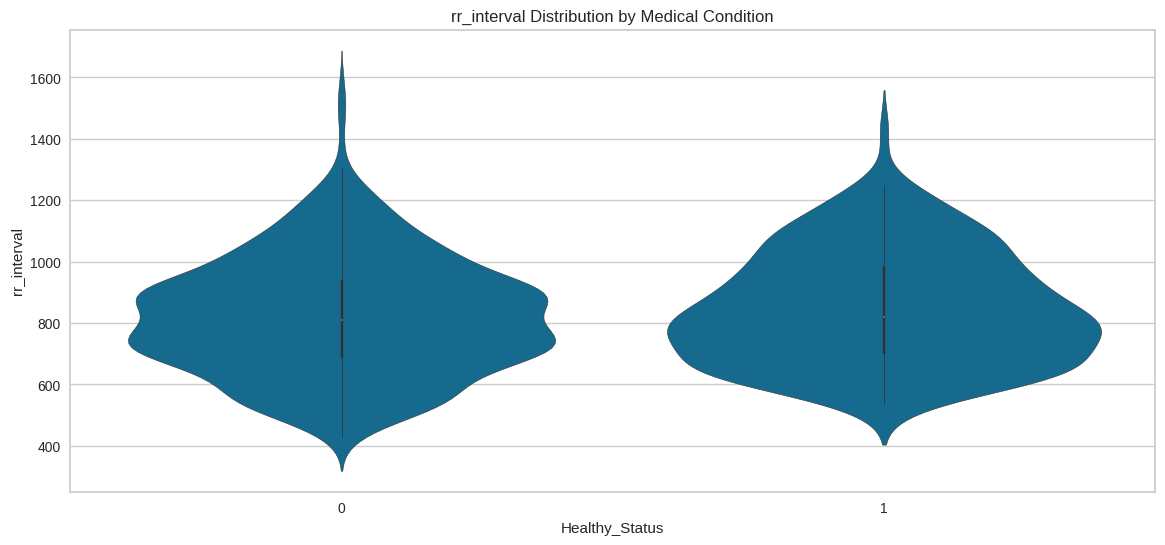

In [ ]:
plt.figure(figsize=(14, 6))
sns.violinplot(data=table_data, y='rr_interval', x='Healthy_Status')
plt.title('rr_interval Distribution by Medical Condition')
plt.show()

# Обработка данных: PCA, ICA, t-SNE

## Методы PCA - principal component analysis

https://web.archive.org/web/20090528101113/http://www.chemometrics.ru/materials/textbooks/pca.htm

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [19]:
#table_data_pca = full_df_filtered
table_data_pca = table_data
table_data_pca = table_data_pca.drop('Healthy_Status', axis = 1)
table_data_pca.columns

Index(['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end',
       'p_axis', 'qrs_axis', 't_axis'],
      dtype='object')

In [20]:
#cancer = load_breast_cancer()
# Before applying PCA, each feature should be centered (zero mean) and with unit variance
scaled_data = StandardScaler().fit(table_data_pca).transform(table_data_pca)
pca = PCA(n_components = 2).fit(scaled_data)
# PCA(copy=True, n_components=2, whiten=False)
x_pca = pca.transform(scaled_data)
print(table_data.shape, x_pca.shape)

(3448, 10) (3448, 2)


In [21]:
percent = pca.explained_variance_ratio_
print(percent)
print(sum(percent))
#To see how much variance is preserved for each dataset.

[0.34547921 0.14287979]
0.48835900686420464


In [22]:
def pca_explained(X, threshold):
  features = X.shape[1]
  for i in range(2, features):
    pca = PCA(n_components = i).fit(X)
    sum_ = pca.explained_variance_ratio_
    # add all components explained variances
    percent = sum(sum_)
    print('{} components at {:.2f}% explained variance'.format(i,percent*100))
    if percent > threshold:
      break

pca_explained(scaled_data, 0.85)

2 components at 48.84% explained variance
3 components at 61.82% explained variance
4 components at 73.60% explained variance
5 components at 82.42% explained variance
6 components at 90.37% explained variance


Text(0, 0.5, 'Second Principal Component')

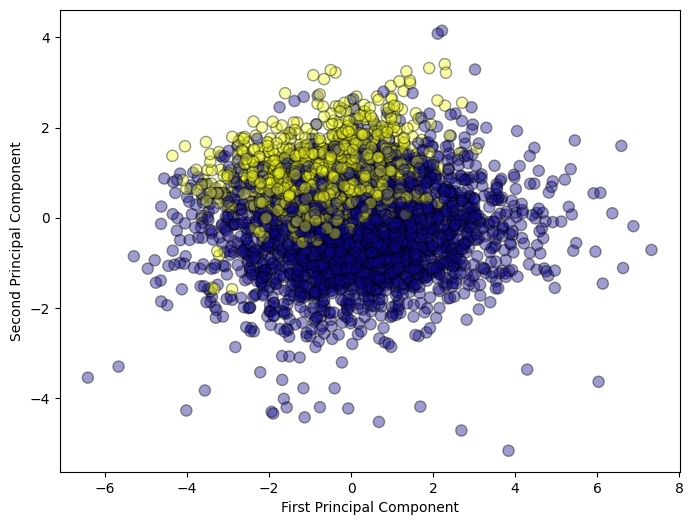

In [23]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

<ipython-input-24-136a607f9ba3>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax2.arrow(0, 0, components['PCA1'][a], -components['PCA2'][a], alpha=0.5, facecolor='white', head_width=.01)
<ipython-input-24-136a607f9ba3>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax2.annotate(i, (components['PCA1'][a]*offset, -components['PCA2'][a]*offset), color='orange')


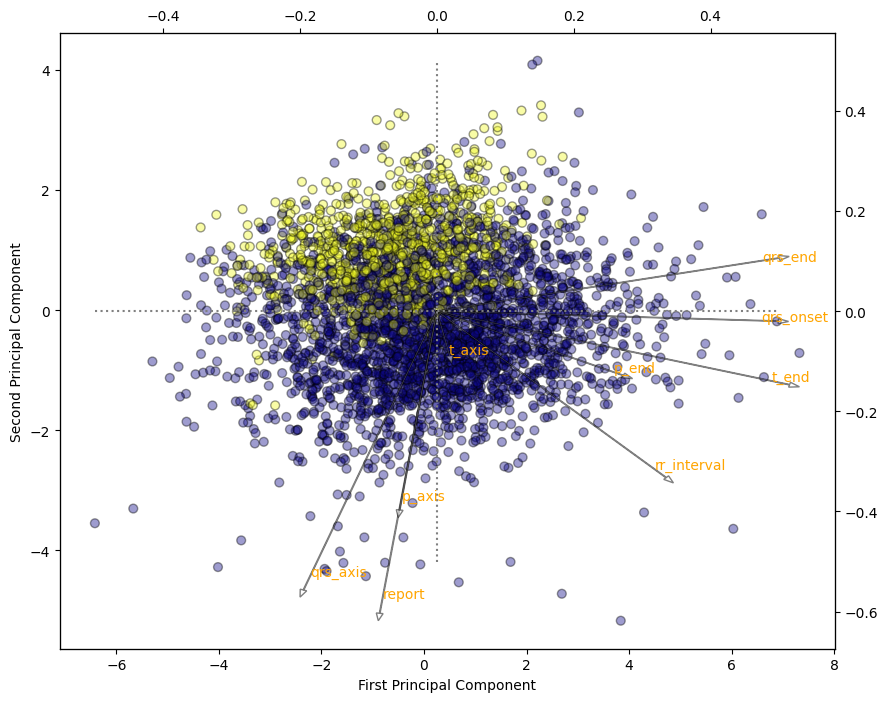

In [24]:
# put feature values into dataframe
components = pd.DataFrame(pca.components_.T, index=table_data_pca.columns, columns= ['PCA1','PCA2'])
# plot size
plt.figure(figsize=(10,8))
# main scatterplot
plt.scatter(x_pca[:,0], x_pca[:,1], c=full_df_filtered['Healthy_Status'],
            cmap='plasma', alpha=0.4, edgecolors='black', s=40);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
#plt.ylim(15,-15);
#plt.xlim(20,-20);

# individual feature values
ax2 = plt.twinx().twiny();
#ax2.set_ylim(-0.5,0.5);
#ax2.set_xlim(-0.5,0.5);

# reference lines
ax2.hlines(0,-0.5,0.5, linestyles='dotted', colors='grey')
ax2.vlines(0,-0.5,0.5, linestyles='dotted', colors='grey')

# offset for labels
offset = 0.95
# arrow & text
for a, i in enumerate(components.index):
  ax2.arrow(0, 0, components['PCA1'][a], -components['PCA2'][a], alpha=0.5, facecolor='white', head_width=.01)
  ax2.annotate(i, (components['PCA1'][a]*offset, -components['PCA2'][a]*offset), color='orange')

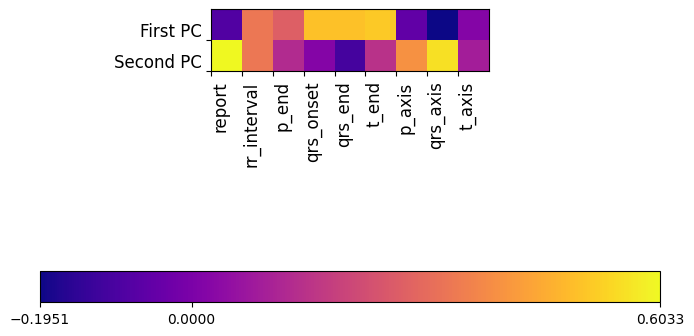

In [25]:
fig = plt.figure(figsize=(8, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
feature_names = list(table_data_pca.columns)
plt.gca().set_xticks(np.arange(-.5, len(feature_names)-1));
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left',fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom',fontsize=12);
plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0,
                                              pca.components_.max()],pad=0.65);

https://www.kaggle.com/code/ellecf/visualizing-multidimensional-clusters

# ML методы

## ML: GussianClassifier + описание классов и матрица ошибок

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
table_data.columns

Index(['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end',
       'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status'],
      dtype='object')

In [ ]:
# set the classification index of table
clf_index = 9

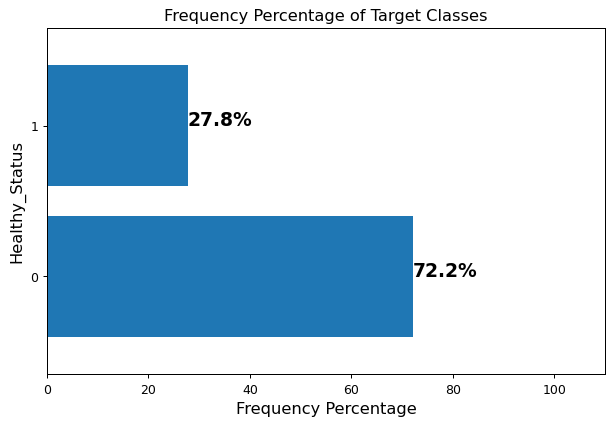

In [ ]:
plt.figure(figsize=(35,20),dpi=90)
# Plot frequency percentages barplot
table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

# Add frequency percentages to the plot
labels = table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=13)
plt.ylabel(table_data.columns[clf_index], fontsize=13)
plt.title('Frequency Percentage of Target Classes', fontsize=13)
plt.show()

In [ ]:
# classification variable
y1 = table_data.iloc[:, clf_index]
# input variable
X1 = table_data.drop(table_data.columns[[clf_index]], axis=1).iloc[:,:]

y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1.values,
                                                        y1.values,
                                                        test_size=0.3,
                                                        random_state=0,
                                                        stratify=y1.values)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X1.values,
                                                 y1.values,
                                                 test_size=0.3,
                                                 random_state=41,
                                                 stratify=y1.values)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2413, 9)
y_train shape: (2413,)
X_test shape: (1035, 9)
y_test shape: (1035,)


In [ ]:
GussianClassifier = GaussianNB()
GussianClassifier.fit(X1_train,y1_train)
y_pred=GussianClassifier.predict(X_test)
print("===================================> Result <===================================")
print("Accuracy                     = " ,metrics.accuracy_score(y_test,y_pred))
print("F1 Score                     = " ,metrics.f1_score(y_test,y_pred))

===================================> Result <===================================
Accuracy                     =  0.9265700483091788
F1 Score                     =  0.8793650793650793


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

              precision    recall  f1-score   support

        True       0.98      0.91      0.95       747
       False       0.81      0.96      0.88       288

    accuracy                           0.93      1035
   macro avg       0.90      0.94      0.91      1035
weighted avg       0.94      0.93      0.93      1035



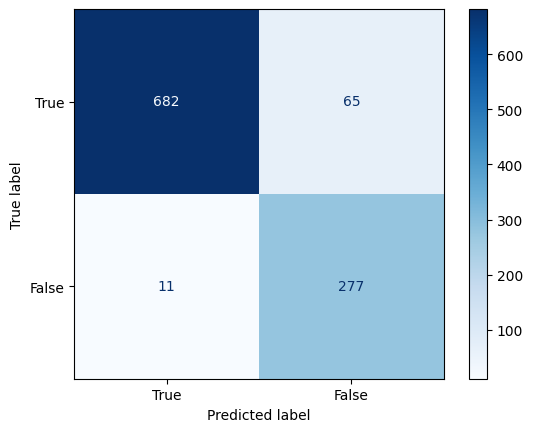

In [ ]:
target_names = ['True', 'False']
labels_names = [0,1]
print(classification_report(y_test, y_pred,labels=labels_names, target_names=target_names))
#cm = confusion_matrix(y_test, y_pred,labels=labels_names,normalize='true')
cm = confusion_matrix(y_test, y_pred,labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

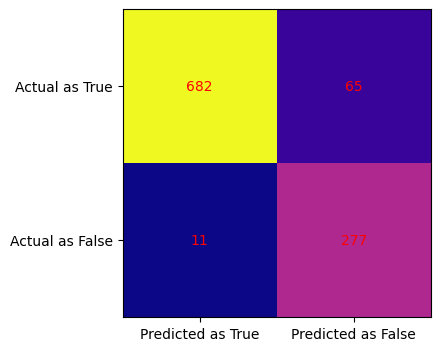

In [ ]:
cm = confusion_matrix(y_test,GussianClassifier.predict(X_test))

fig , ax  = plt.subplots(figsize=(4,4))
ax.imshow(cm, cmap = 'plasma')
ax.grid(False)
ax.xaxis.set(ticks=(0,1),ticklabels=("Predicted as True","Predicted as False"))
ax.yaxis.set(ticks=(0,1),ticklabels=("Actual as True","Actual as False"))
ax.set_ylim(1.5,-0.5)
for i in range(2):
    for j in range(2):
        ax.text(j,i,cm[i,j],ha="center",va="center",color = "red")

# AutoML examples

In [26]:
# Убираем из датасета лишние столбцы
# Формируем датасет для AutoML методов
autoML_df = full_df_filtered[['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()


## AutoML H2O

In [27]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.8/265.8 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.6-py2.py3-none-any.whl size=265859786 sha256=072f97c85ff1d86821688ca58d20f24829c55ec73eb1f63fea59a84cbbcf5691
  Stored in directory: /root/.cache/pip/wheels/62/f9/aa/687bd54342d2981bc78e22ee9b9bc39f92006e344e7aa1e0ac
Successfully built h2o


In [44]:
import h2o
from h2o.frame import H2OFrame
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score

In [29]:
# Инициализируем H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpoyr1ruly
  JVM stdout: /tmp/tmpoyr1ruly/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpoyr1ruly/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.6
H2O_cluster_version_age:    4 months and 18 days
H2O_cluster_name:           H2O_from_python_unknownUser_vkllwz
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.170 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.11.11 final
--------------------------  -----------------------------------------------------------------------------------------

In [30]:
# Переводим датафрейм в формат H2OFrame
h2o_df = H2OFrame(autoML_df)

# Разбиение на обучающую и тестовую выборки
random_seed = 17
train, test = h2o_df.split_frame(ratios=[0.85], seed=random_seed)

# Определяем целевую переменную и предикторы
y="Healthy_Status"
x = list(h2o_df.columns)
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [31]:
# Создаем и обучаем модель H2O AutoML
automl = H2OAutoML(max_runtime_secs=60, seed=random_seed, verbosity="info")
#automl= H2OAutoML(max_models = 10, seed = 10, exclude_algos = ["StackedEnsemble", "DeepLearning"], verbosity="info", nfolds=0)


automl.train(x=x, y=y, training_frame=train)

# Оценка модели на тестовом наборе
performance = automl.leader.model_performance(test_data=test)
print(performance)

AutoML progress: |
12:55:42.305: Project: AutoML_1_20250320_125542
12:55:42.307: 5-fold cross-validation will be used.
12:55:42.308: Setting stopping tolerance adaptively based on the training frame: 0.018464772811525407
12:55:42.308: Build control seed: 17
12:55:42.309: training frame: Frame key: AutoML_1_20250320_125542_training_py_2_sid_8fce    cols: 10    rows: 2933  chunks: 1    size: 68508  checksum: -8749811713305476237
12:55:42.309: validation frame: NULL
12:55:42.310: leaderboard frame: NULL
12:55:42.310: blending frame: NULL
12:55:42.310: response column: Healthy_Status
12:55:42.310: fold column: null
12:55:42.310: weights column: null
12:55:42.343: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (6g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4g, 60w), lr_annealing (6g, 10w)

In [32]:
lb = automl.leaderboard
lb.head()

model_id                                                     rmse        mse        mae      rmsle    mean_residual_deviance
-------------------------------------------------------  --------  ---------  ---------  ---------  ------------------------
StackedEnsemble_BestOfFamily_3_AutoML_1_20250320_125542  0.110078  0.0121171  0.0389365  0.0783399                 0.0121171
StackedEnsemble_AllModels_2_AutoML_1_20250320_125542     0.11085   0.0122878  0.0391175  0.0789459                 0.0122878
StackedEnsemble_AllModels_1_AutoML_1_20250320_125542     0.111274  0.0123819  0.0410553  0.0797737                 0.0123819
StackedEnsemble_BestOfFamily_2_AutoML_1_20250320_125542  0.111725  0.0124825  0.042023   0.0802472                 0.0124825
GBM_2_AutoML_1_20250320_125542                           0.112067  0.0125591  0.0419002  0.080496                  0.0125591
GBM_3_AutoML_1_20250320_125542                           0.113895  0.012972   0.0396432  0.0819404                 0.012972
XGBoost_3_AutoML_1_20250320_125542                       0.113944  0.0129832  0.0423476  0.0815533                 0.0129832
GBM_4_AutoML_1_20250320_125542                           0.115667  0.0133789  0.0511616  0.0842526                 0.0133789
StackedEnsemble_BestOfFamily_1_AutoML_1_20250320_125542  0.122663  0.0150461  0.056395   0.0885909                 0.0150461
XGBoost_1_AutoML_1_20250320_125542                       0.127412  0.0162339  0.0657838  0.0941351                 0.0162339
[10 rows x 6 columns]

In [33]:
model_ids = list(automl.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_ids

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


['StackedEnsemble_BestOfFamily_3_AutoML_1_20250320_125542',
 'StackedEnsemble_AllModels_2_AutoML_1_20250320_125542',
 'StackedEnsemble_AllModels_1_AutoML_1_20250320_125542',
 'StackedEnsemble_BestOfFamily_2_AutoML_1_20250320_125542',
 'GBM_2_AutoML_1_20250320_125542',
 'GBM_3_AutoML_1_20250320_125542',
 'XGBoost_3_AutoML_1_20250320_125542',
 'GBM_4_AutoML_1_20250320_125542',
 'StackedEnsemble_BestOfFamily_1_AutoML_1_20250320_125542',
 'XGBoost_1_AutoML_1_20250320_125542',
 'DRF_1_AutoML_1_20250320_125542',
 'GBM_1_AutoML_1_20250320_125542',
 'GBM_5_AutoML_1_20250320_125542',
 'XRT_1_AutoML_1_20250320_125542',
 'XGBoost_2_AutoML_1_20250320_125542',
 'DeepLearning_1_AutoML_1_20250320_125542',
 'GLM_1_AutoML_1_20250320_125542',
 'GBM_grid_1_AutoML_1_20250320_125542_model_1',
 'XGBoost_grid_1_AutoML_1_20250320_125542_model_1']

In [34]:
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'silent': True,
  'eta': 0.3,
  'colsample_bylevel': 0.8,
  'objective': 'reg:squarederror',
  'min_child_weight': 3.0,
  'nthread': 2,
  'seed': 28,
  'max_depth': 5,
  'colsample_bytree': 0.8,
  'lambda': 1.0,
  'gamma': 0.0,
  'alpha': 0.0,
  'booster': 'gbtree',
  'grow_policy': 'depthwise',
  'nround': 14,
  'subsample': 0.8,
  'max_delta_step': 0.0,
  'tree_method': 'exact'},
 14)

In [35]:
automl.leader.model_performance(test)

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.007917322630118222
RMSE: 0.08897933822027573
MAE: 0.03818402237376397
RMSLE: 0.06496635667983598
Mean Residual Deviance: 0.007917322630118222
R^2: 0.9569257047267056
Null degrees of freedom: 514
Residual degrees of freedom: 512
Null deviance: 95.56748634029051
Residual deviance: 4.077421154510884
AIC: -1022.4249345605642

In [36]:
test_predict = automl.predict(test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


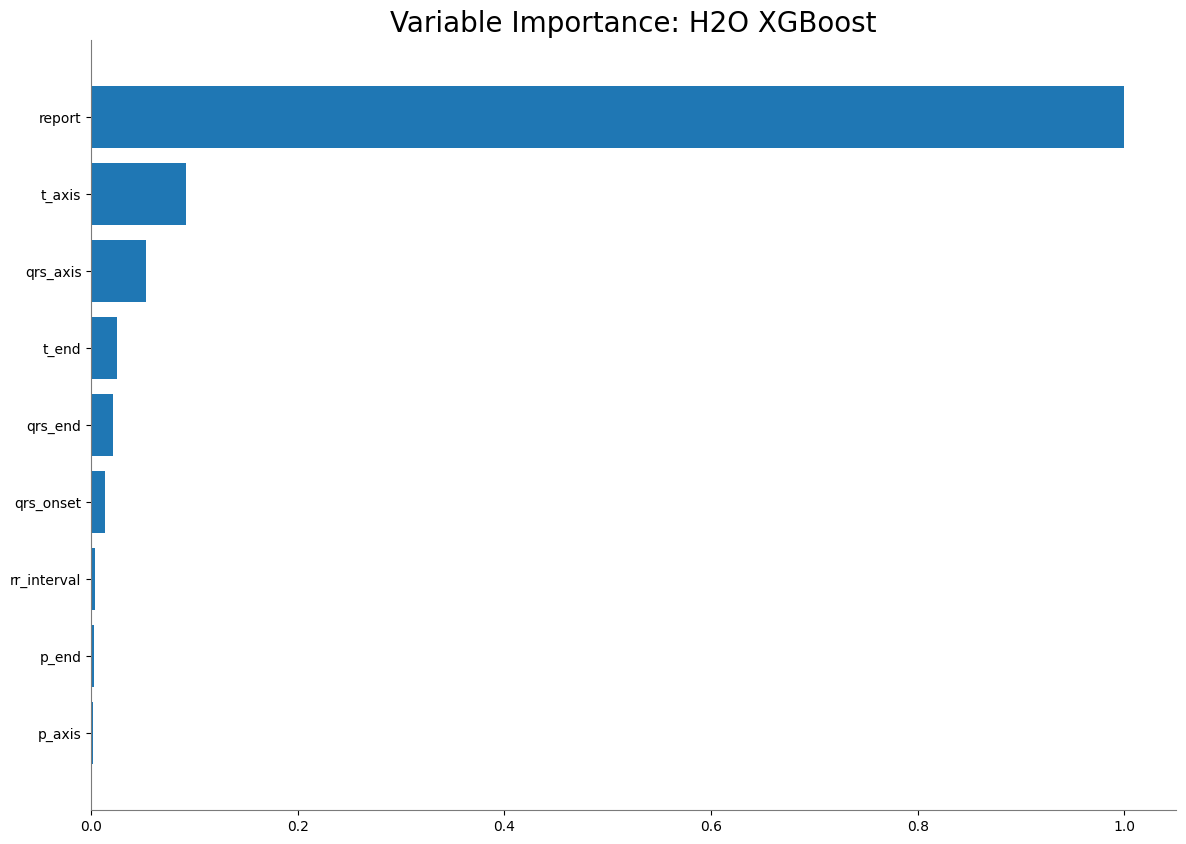

<Figure size 640x480 with 0 Axes>

In [37]:
out.varimp_plot()

In [38]:
# H2OFrame
test_preds = h2o.as_list(test_predict)
test_preds = test_preds['predict']

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [39]:
test_Y = h2o.as_list(test['Healthy_Status'])
test_Y = test_Y['Healthy_Status']

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [45]:
# Вычисляем F1-меру с помощью confusion matrix

# Порог отсечения - 0.5
for i in range(len(test_preds)):
  if test_preds[i] > 0.5:
    test_preds[i] = 1
  else:
    test_preds[i] = 0


cm = confusion_matrix(test_Y, test_preds)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

roc_auc = roc_auc_score(test_Y, test_preds)

print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

Confusion matrix: [[390   0]
 [  3 122]]
F1-Score:  0.99
Accuracy: 0.99
Recall:  0.98
Precision:  1.00


In [ ]:
# Завершение работы H2O
h2o.shutdown()

## AutoML AutoGluon

In [ ]:
!pip install autogluon --quiet
!pip install autogluon.tabular[lightgbm] --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-eda 0.8.3 requires autogluon.common==0.8.3, but you have autogluon-common 1.2 which is incompatible.
autogluon-eda 0.8.3 requires autogluon.core==0.8.3, but you have autogluon-core 1.2 which is incompatible.
autogluon-eda 0.8.3 requires autogluon.features==0.8.3, but you have autogluon-features 1.2 which is incompatible.
autogluon-eda 0.8.3 requires autogluon.tabular==0.8.3, but you have autogluon-tabular 1.2 which is incompatible.
autogluon-eda 0.8.3 requires matplotlib<3.7,>=3.4, but you have matplotlib 3.10.0 which is incompatible.
autogluon-eda 0.8.3 requires pandas<1.6,>=1.4.1, but you have pandas 2.2.3 which is incompatible.
autogluon-eda 0.8.3 requires scikit-learn<1.4.1,>=1.1, but you have scikit-learn 1.4.2 which is incompatible.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pa

In [ ]:
import autogluon

In [ ]:
# Импортируем необходимые библиотеки
from autogluon.tabular import TabularPredictor

In [ ]:
autoML_df.head()

report  rr_interval  p_end  qrs_onset  qrs_end  t_end  p_axis  qrs_axis  \
0  0.015189          659    128        170      258    518      81        77   
1  0.015189          722    124        162      246    504      77        75   
2  0.036174          600    130        162      244    474      79        72   
3  0.023268          659    146        180      254    538      79        66   
6  0.023268          952    146        198      282    598      24        80   

   t_axis  Healthy_Status  
0      79               0  
1      70               0  
2      77               1  
3      69               1  
6      20               1

In [ ]:
# Разбиение на обучающую и тестовую выборки
random_seed = 17

# set the classification index of table
clf_index = 9

target = 'Healthy_Status'

auto_X = autoML_df.iloc[:, :clf_index]
auto_Y = autoML_df.iloc[:, [clf_index]]
auto_X_train, auto_X_test, auto_Y_train, auto_Y_test = train_test_split(
                                                        auto_X, auto_Y,
                                                        train_size=0.85,
                                                        random_state=random_seed,
                                                        stratify=auto_Y
                                                        )

# Создаем обучающий датафрейм
auto_train_df = auto_X_train.copy()
auto_test_df = auto_X_test.copy()
auto_train_df['Healthy_Status'] = auto_Y_train
auto_test_df['Healthy_Status'] = auto_Y_test

In [ ]:
# Создаем и обучаем модель
predictor = TabularPredictor(label='Healthy_Status', eval_metric='accuracy').fit(train_data=auto_train_df)

# Предсказание на тестовой выборке
y_pred = predictor.predict(auto_X_test)

No path specified. Models will be saved in: "AutogluonModels/ag-20241222_122555"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       10.66 GB / 12.67 GB (84.1%)
Disk Space Avail:   72.74 GB / 107.72 GB (67.5%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions 

In [ ]:
predictor.leaderboard(auto_test_df)

model  score_test  score_val eval_metric  pred_time_test  \
0              CatBoost    0.982625   0.986028    accuracy        0.007593   
1   WeightedEnsemble_L2    0.982625   0.986028    accuracy        0.010864   
2              LightGBM    0.980695   0.982036    accuracy        0.012407   
3         LightGBMLarge    0.976834   0.982036    accuracy        0.009017   
4               XGBoost    0.971042   0.982036    accuracy        0.018660   
5      RandomForestGini    0.971042   0.976048    accuracy        0.133603   
6      RandomForestEntr    0.969112   0.974052    accuracy        0.140145   
7        ExtraTreesEntr    0.969112   0.974052    accuracy        0.144106   
8        ExtraTreesGini    0.967181   0.974052    accuracy        0.138621   
9            LightGBMXT    0.957529   0.972056    accuracy        0.039678   
10      NeuralNetFastAI    0.949807   0.970060    accuracy        0.046856   
11       KNeighborsDist    0.743243   0.750499    accuracy        0.040169   
12       KNeighborsUnif    0.739382   0.746507    accuracy        0.038784   

    pred_time_val  fit_time  pred_time_test_marginal  pred_time_val_marginal  \
0        0.001050  1.509761                 0.007593                0.001050   
1        0.002301  1.651642                 0.003270                0.001251   
2        0.002788  0.598345                 0.012407                0.002788   
3        0.002987  1.173323                 0.009017                0.002987   
4        0.004163  0.316003                 0.018660                0.004163   
5        0.066284  1.819698                 0.133603                0.066284   
6        0.077252  2.050978                 0.140145                0.077252   
7        0.086359  0.858492                 0.144106                0.086359   
8        0.085909  0.838698                 0.138621                0.085909   
9        0.014078  0.561010                 0.039678                0.014078   
10       0.012080  2.974478                 0.046856                0.012080   
11       0.013767  0.011395                 0.040169                0.013767   
12       0.013848  0.013412                 0.038784                0.013848   

    fit_time_marginal  stack_level  can_infer  fit_order  
0            1.509761            1       True          7  
1            0.141881            2       True         13  
2            0.598345            1       True          4  
3            1.173323            1       True         12  
4            0.316003            1       True         11  
5            1.819698            1       True          5  
6            2.050978            1       True          6  
7            0.858492            1       True          9  
8            0.838698            1       True          8  
9            0.561010            1       True          3  
10           2.974478            1       True         10  
11           0.011395            1       True          2  
12           0.013412            1       True          1

In [ ]:
!pip install autogluon.eda --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon 1.2 requires autogluon.core[all]==1.2, but you have autogluon-core 0.8.3 which is incompatible.
autogluon 1.2 requires autogluon.features==1.2, but you have autogluon-features 0.8.3 which is incompatible.
autogluon 1.2 requires autogluon.tabular[all]==1.2, but you have autogluon-tabular 0.8.3 which is incompatible.
autogluon-multimodal 1.2 requires autogluon.common==1.2, but you have autogluon-common 0.8.3 which is incompatible.
autogluon-multimodal 1.2 requires autogluon.core[raytune]==1.2, but you have autogluon-core 0.8.3 which is incompatible.
autogluon-multimodal 1.2 requires autogluon.features==1.2, but you have autogluon-features 0.8.3 which is incompatible.
autogluon-multimodal 1.2 requires pandas<2.3.0,>=2.0.0, but you have pandas 1.5.3 which is incompatible.
autogluon-timeseries 1.2 requires au

In [ ]:
import autogluon.eda.auto as auto

In [ ]:
!pip install autogluon==1.2 --quiet

In [ ]:
# scikit-learn moves the check_pandas_support api,
# HAVE TO downgrade to scikit-learn <= 1.4.2 can solve the problem
!pip install scikit-learn==1.4.2

  Using cached scikit_learn-1.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.0
    Uninstalling scikit-learn-1.4.0:
      Successfully uninstalled scikit-learn-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-core 0.8.3 requires scikit-learn<1.4.1,>=1.1, but you have scikit-learn 1.4.2 which is incompatible.
autogluon-eda 0.8.3 requires scikit-learn<1.4.1,>=1.1, but you have scikit-learn 1.4.2 which is incompatible.
autogluon-features 0.8.3 requires scikit-learn<1.4.1,>=1.1, but you have scikit-learn 1.4.2 which is incompatible.
autogluon-multimodal 1.2 requires autogluon.common==1.2, but you have autogluon-common 0.8.3 which is 

In [ ]:
auto.target_analysis(train_data=auto_train_df, label=target)

ModuleNotFoundError: No module named 'pandas.core.methods.to_dict'

In [ ]:
auto.dataset_overview(train_data=auto_train_df,
                      test_data=auto_test_df,
                      label=target)

ModuleNotFoundError: No module named 'pandas.core.methods.to_dict'

In [ ]:
predictor.quick_fit(auto_train_df, target_col=target, show_feature_importance_barplots=True)


AttributeError: 'TabularPredictor' object has no attribute 'quick_fit'

## AutoML BlueCast

https://github.com/ThomasMeissnerDS/BlueCast.git

https://www.kaggle.com/code/thomasmeiner/ps3e24-bluecast-eda-automl-tracking

In [ ]:
!pip install bluecast --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "

In [ ]:
import numpy as np
import pandas as pd
import re


from bluecast.blueprints.cast import BlueCast
from bluecast.blueprints.cast_cv import BlueCastCV
from bluecast.config.training_config import TrainingConfig, XgboostTuneParamsConfig
from bluecast.preprocessing.custom import CustomPreprocessing
from bluecast.general_utils.general_utils import save_to_production, load_for_production

from sklearn.model_selection import StratifiedKFold, RepeatedKFold

In [ ]:
# Убираем из датасета лишние столбцы
autoML_df = full_df_filtered[['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()

autoML_df = autoML_df.drop(columns='report')

# Разбиение на обучающую и тестовую выборки

random_seed = 13

# set the classification index of table
clf_index = autoML_df.shape[1]-1

auto_X = autoML_df.iloc[:, :clf_index]
auto_Y = autoML_df.iloc[:, [clf_index]]
auto_X_train, auto_X_test, auto_Y_train, auto_Y_test = train_test_split(auto_X, auto_Y, train_size=0.85, random_state=random_seed, stratify=auto_Y)

# Склеиваем признаки и таргеты в один датафрейм (только для обучающей выборки)
auto_train_df = auto_X_train
auto_train_df['Healthy_Status'] = auto_Y_train

# Создаем и обучаем модель
#automl = BlueCast(class_problem="binary")
#automl.fit(auto_train_df, target_col="Healthy_Status")

In [ ]:
#  Пример загрузки данных
#table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=5000)

#df = table_data

# Проверка формы набора данных
#print('исходный набор данных: ',df.shape)

# Инициализация начального числа для генераторов случайных чисел
seed = 13

target = 'Healthy_Status'

# Создание обучающего набора с помощью выборки pandas — видимый набор данных
train_dataset = autoML_df.sample(frac=.8, random_state=seed)
#knowledge.reset_index(inplace=True, drop=True)
print('выделяем из исходного набора данныз базу для обучения: ', train_dataset.shape)

# Использование образцов, недоступных в обучающем наборе, в качестве будущего или невидимого набора данных
test_dataset = autoML_df.drop(train_dataset.index)
#payload.reset_index(inplace=True, drop=True)
print('набор данных для проверки: ',test_dataset.shape)


выделяем из исходного набора данныз базу для обучения:  (2758, 9)
набор данных для проверки:  (690, 9)


In [ ]:
# Предобрабатываем данные

full_df = df

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
#columns_to_filter = ['rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = full_df[(full_df[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Фиксим имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

full_df_filtered.head()

subject_id  Count_subj  study_id  cart_id  eeg_time    eeg_date  \
0    19557662          27  40000017  6848296   8:44 AM  27.06.2015   
1    18477137          93  40000029  6848296   9:54 AM  27.06.2015   
2    16598616           3  40000035  6376932   9:07 AM  28.06.2015   
3    16368287           7  40000079  6214760   5:14 PM  15.07.2015   
6    12576058          43  40000115  6852956  12:54 PM  23.03.2016   

                                              report     bandwidth  \
0  Sinus rhythm Possible right atrial abnormality...  0.005-150 Hz   
1  Sinus rhythm Possible right atrial abnormality...  0.005-150 Hz   
2       Sinus tachycardia Normal ECG except for rate  0.005-150 Hz   
3                            Sinus rhythm Normal ECG  0.005-150 Hz   
6                            Sinus rhythm Normal ECG  0.005-150 Hz   

                     filtering  rr_interval  p_onset  p_end  qrs_onset  \
0  60 Hz notch Baseline filter          659       40    128        170   
1  60 Hz notch Baseline filter          722       40    124        162   
2  60 Hz notch Baseline filter          600       40    130        162   
3  60 Hz notch Baseline filter          659       40    146        180   
6  60 Hz notch Baseline filter          952       40    146        198   

   qrs_end  t_end  p_axis  qrs_axis  t_axis  Healthy_Status  
0      258    518      81        77      79               0  
1      246    504      77        75      70               0  
2      244    474      79        72      77               1  
3      254    538      79        66      69               1  
6      282    598      24        80      20               1

In [ ]:
full_df_filtered['report']

0       Sinus rhythm Possible right atrial abnormality...
1       Sinus rhythm Possible right atrial abnormality...
2            Sinus tachycardia Normal ECG except for rate
3                                 Sinus rhythm Normal ECG
6                                 Sinus rhythm Normal ECG
                              ...                        
4967    Sinus rhythm Anterior T wave changes are nonsp...
4969    Sinus rhythm Possible left atrial abnormality ...
4970    Sinus rhythm Possible left atrial abnormality ...
4971    Sinus rhythm Possible left atrial abnormality ...
4989    Sinus tachycardia - premature ventricular cont...
Name: report, Length: 3448, dtype: object

In [ ]:
from bluecast.preprocessing.feature_types import FeatureTypeDetector

feat_type_detector = FeatureTypeDetector()
train_data = feat_type_detector.fit_transform_feature_types(train_dataset)

len(feat_type_detector.num_columns)

10

In [ ]:
#Automatic feature type detection from BlueCast
print(feat_type_detector.date_columns)

[]


In [ ]:
feat_type_detector.num_columns

['rr_interval',
 'p_end',
 'qrs_onset',
 'qrs_end',
 't_end',
 'p_axis',
 'qrs_axis',
 't_axis',
 'Healthy_Status',
 'report']

In [ ]:
feat_type_detector.cat_columns

[]

In [ ]:
from bluecast.eda.analyse import (
    bi_variate_plots,
    correlation_heatmap,
    correlation_to_target,
    plot_pca,
    plot_theil_u_heatmap,
    plot_tsne,
    univariate_plots,
    check_unique_values,
    plot_null_percentage
)

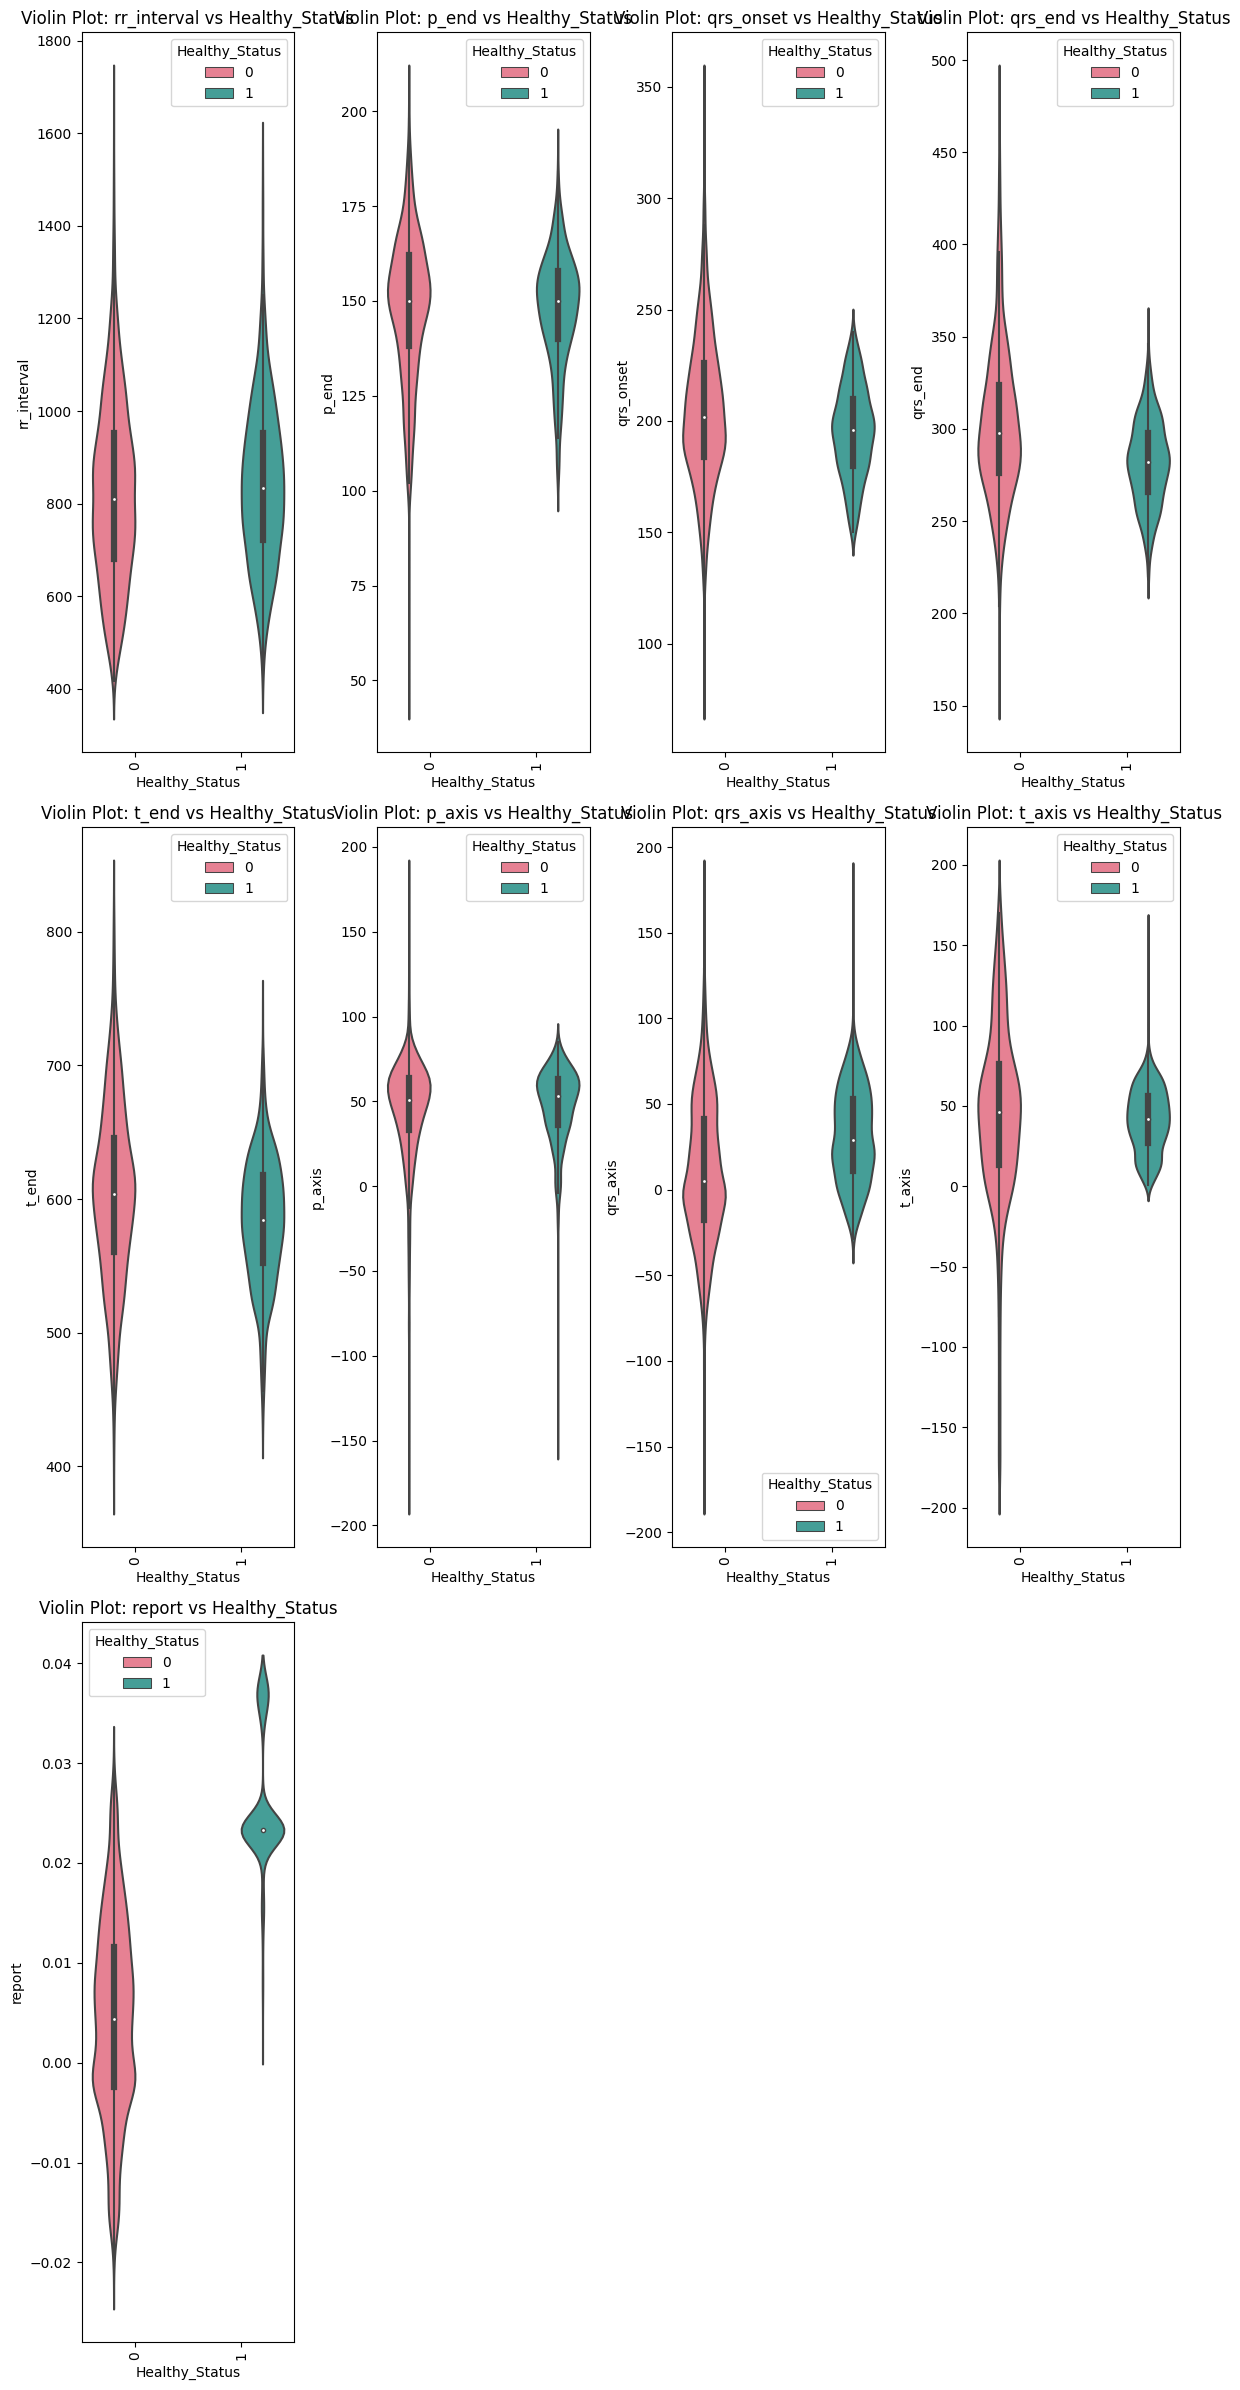

In [ ]:
bi_variate_plots(
        full_df_filtered.loc[
            :, feat_type_detector.num_columns
        ],
        target,
    )

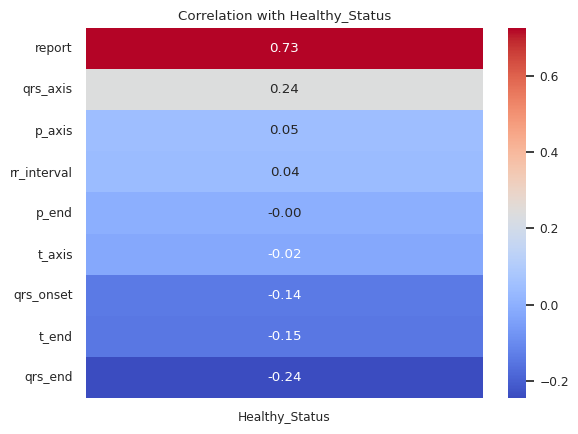

In [ ]:
# show correlation to target
correlation_to_target(
    full_df_filtered.loc[:, feat_type_detector.num_columns],
      target,
      )

In [ ]:
#no_correlation = ["p_axis", "p_end", "t_axis"]

no_correlation = ["p_onset", "subject_id", "p_end", "cart_id", "Count_subj"]

train = full_df_filtered.drop(no_correlation, axis=1)
test = full_df_filtered.drop(no_correlation, axis=1)

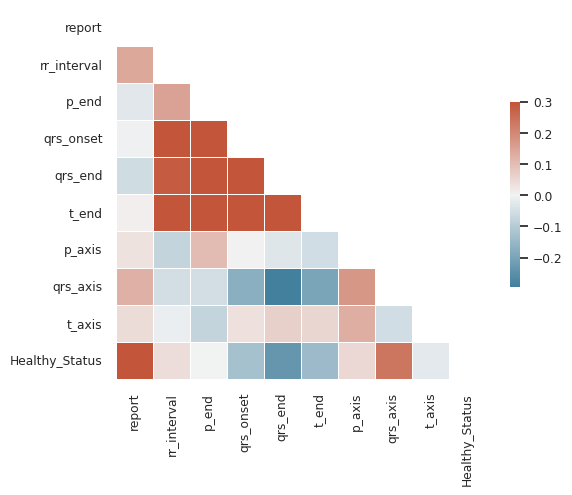

In [ ]:
correlation_heatmap(train_data.loc[
            :, train_data.columns.values])

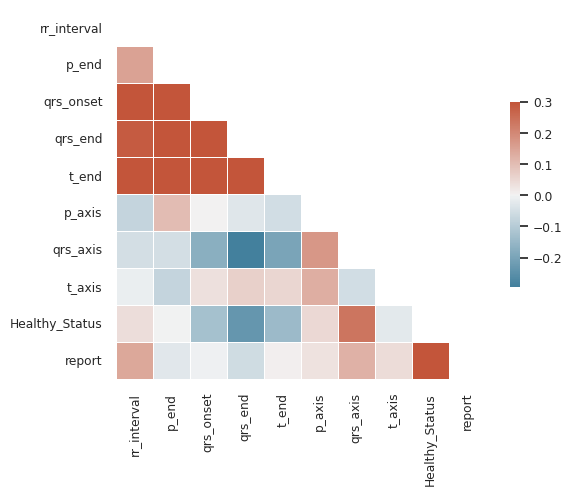

In [ ]:
correlation_heatmap(train_data.loc[
            :, feat_type_detector.num_columns])

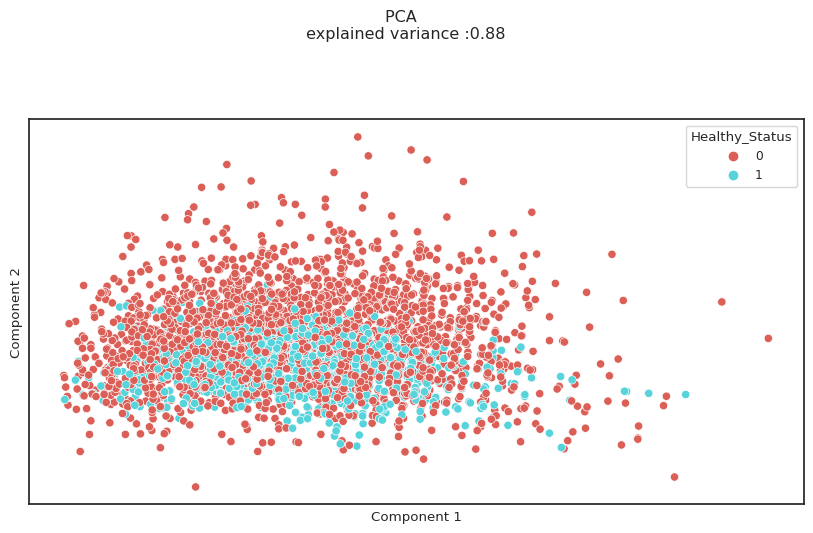

In [ ]:
# show feature space after principal component analysis
plot_pca(autoML_df.loc[
            :, feat_type_detector.num_columns
        ].fillna(0), target)

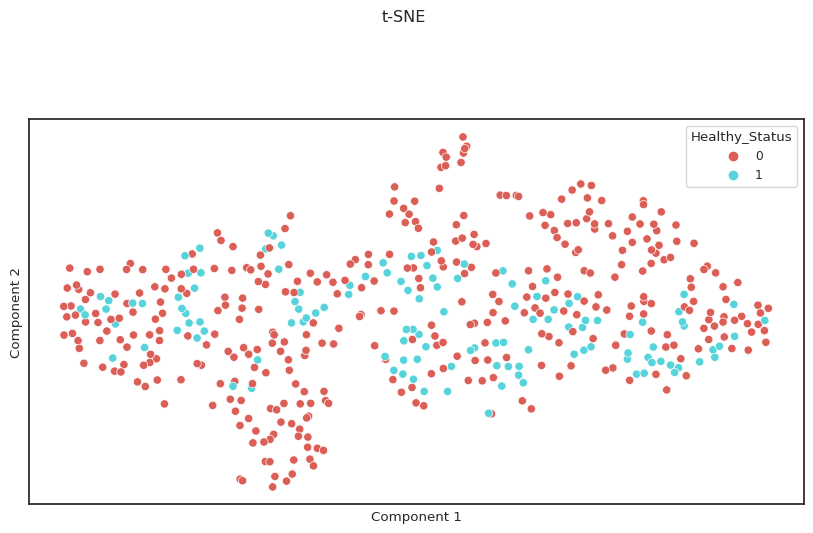

In [ ]:
# show feature space after t-SNE
plot_tsne(autoML_df.loc[
            :, feat_type_detector.num_columns
        ].sample(500, random_state=42).fillna(0), target, perplexity=30, random_state=0)

In [ ]:
from bluecast.eda.data_leakage_checks import (
    detect_categorical_leakage,
    detect_leakage_via_correlation,
)

In [ ]:
# Detect leakage of numeric columns based on correlation
numresult = detect_leakage_via_correlation(
        train_data.loc[:, feat_type_detector.num_columns].fillna(0), target, threshold=0.9 # target column is part of detected numerical columns here
    )

No leakage has been detected


In [ ]:
# Detect leakage of categorical columns based on Theil's U
result = detect_categorical_leakage(
        train_data.loc[:, feat_type_detector.cat_columns + [target]], target, threshold=0.9
    )

No leakage has been detected


In [ ]:
automl = BlueCast(class_problem="binary")

automl.conf_training.hyperparameter_tuning_rounds = 10
automl.conf_training.calculate_shap_values = False
automl.conf_training.use_full_data_for_final_model = False

2025-03-03 19:19:34,854 - root - INFO - BlueCast blueprint initialized.


2025-03-03 19:19:46,000 - root - INFO - Start detecting and casting feature types.
2025-03-03 19:19:46,005 - root - INFO - Dropped the following columns as being Nulls only: [].
2025-03-03 19:19:46,006 - root - INFO - Dropped the following columns as being Nulls only: [].
2025-03-03 19:19:46,009 - root - INFO - Dropped the following columns as constants only: [].
2025-03-03 19:19:46,010 - root - INFO - Dropped the following columns as constants only: [].
2025-03-03 19:19:46,065 - root - WARNING - /usr/local/lib/python3.11/dist-packages/bluecast/blueprints/cast.py:295: UserWarning: Feature selection is disabled. Update the TrainingConfig param 'enable_feature_selection'
            to enable it or make use of a custom preprocessor to do it manually during the last mile computations step.
            Feature selection is recommended for datasets with many features (>1000). For datasets with a small amount
            of features feature selection is not recommended.
            
2025-03-

  0%|          | 0/10 [00:00<?, ?it/s]

2025-03-03 19:22:51,171 - root - INFO - New best score: 0.37882818208837554 from random seed  33
2025-03-03 19:22:51,177 - root - INFO - Best params: {'validate_parameters': False, 'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'mlogloss', 'num_class': 2, 'max_depth': 3, 'alpha': 1.5311302050301745e-05, 'lambda': 2.0889560100230935, 'gamma': 0.22114169335491826, 'min_child_weight': 7.460608390823226, 'subsample': 1.0, 'colsample_bytree': 0.8433310708488493, 'colsample_bylevel': 0.8776067335500239, 'eta': 0.18299142989294398, 'steps': 1000, 'tree_method': 'approx', 'grow_policy': 'lossguide', 'max_bin': 585}
2025-03-03 19:22:51,182 - root - INFO - Start final model training


Best params: {'validate_parameters': False, 'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'mlogloss', 'num_class': 2, 'max_depth': 3, 'alpha': 1.5311302050301745e-05, 'lambda': 2.0889560100230935, 'gamma': 0.22114169335491826, 'min_child_weight': 7.460608390823226, 'subsample': 1.0, 'colsample_bytree': 0.8433310708488493, 'colsample_bylevel': 0.8776067335500239, 'eta': 0.18299142989294398, 'steps': 1000, 'tree_method': 'approx', 'grow_policy': 'lossguide', 'max_bin': 585}
Finished hyperparameter tuning


2025-03-03 19:22:52,710 - root - INFO - Finished training
2025-03-03 19:22:52,719 - root - INFO - Start casting feature types.
2025-03-03 19:22:52,721 - root - INFO - Dropped the following columns as being Nulls only: [].
2025-03-03 19:22:52,724 - root - INFO - Dropped the following columns as constants only: [].
2025-03-03 19:22:52,726 - root - INFO - Start filling infinite values.
2025-03-03 19:22:52,730 - root - INFO - Start date column conversion (transform).
2025-03-03 19:22:52,730 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2025-03-03 19:22:52,732 - root - INFO - Start transforming categories with binary target encoder.
2025-03-03 19:22:52,733 - root - INFO - Start transforming categories with binary target encoder.
2025-03-03 19:22:52,739 - root - INFO - Predicting...
2025-03-03 19:22:52,740 - root - INFO - Start predicting on new data using Xgboost model.
2025-03-03 19:22:52,797 - root - INFO - Finished predicting
2025-03-03 

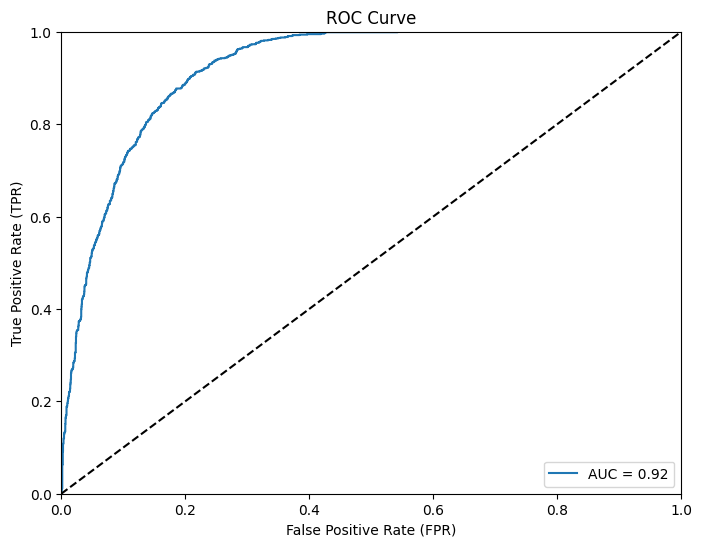

2025-03-03 19:22:53,063 - root - WARNING - /usr/local/lib/python3.11/dist-packages/bluecast/evaluation/eval_metrics.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


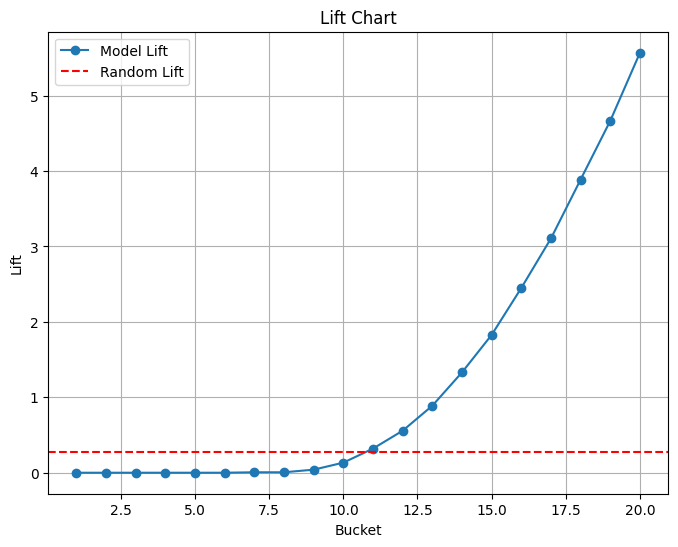

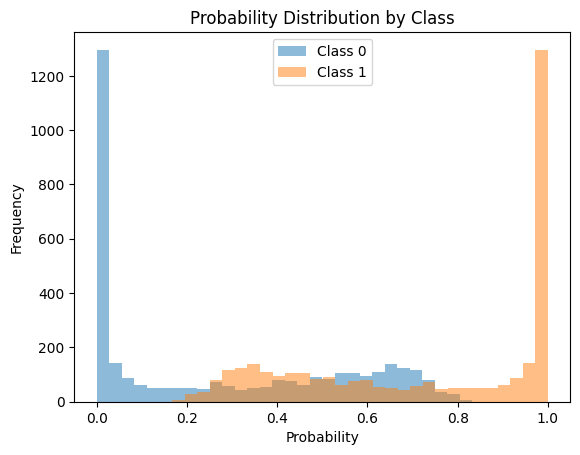

2025-03-03 19:22:53,603 - root - INFO - Start saving out of fold data.


{'matthews': 0.6235010142708188,
 'accuracy': 0.8454176334106729,
 'recall': 0.8454176334106729,
 'f1_score_macro': 0.8113638222879413,
 'f1_score_micro': 0.8454176334106729,
 'f1_score_weighted': 0.8468820635135618,
 'log_loss': 0.32296826052098154,
 'balanced_logloss': 0.40763336420059204,
 'roc_auc': 0.9203792788719185,
 'classfication_report': '              precision    recall  f1-score   support\n\n           0       0.90      0.88      0.89      2488\n           1       0.71      0.76      0.73       960\n\n    accuracy                           0.85      3448\n   macro avg       0.81      0.82      0.81      3448\nweighted avg       0.85      0.85      0.85      3448\n',
 'confusion_matrix': array([[2190,  298],
        [ 235,  725]])}

In [ ]:
automl.fit_eval(
    df=autoML_df,
    df_eval=autoML_df.drop('Healthy_Status', axis=1),
    target_eval=autoML_df['Healthy_Status'],
    target_col="Healthy_Status",
)

In [ ]:
y_probs, test_preds = automl.predict(auto_X_test)

# Вычисляем F1-меру с помощью confusion matrix
cm = confusion_matrix(auto_Y_test, test_preds)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

roc_auc = roc_auc_score(auto_Y_test, test_preds)

print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

2025-03-03 19:24:03,322 - root - INFO - Start casting feature types.
2025-03-03 19:24:03,324 - root - INFO - Dropped the following columns as being Nulls only: [].
2025-03-03 19:24:03,325 - root - INFO - Dropped the following columns as constants only: [].
2025-03-03 19:24:03,326 - root - INFO - Start filling infinite values.
2025-03-03 19:24:03,327 - root - INFO - Start date column conversion (transform).
2025-03-03 19:24:03,328 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2025-03-03 19:24:03,330 - root - INFO - Start transforming categories with binary target encoder.
2025-03-03 19:24:03,332 - root - INFO - Start transforming categories with binary target encoder.
2025-03-03 19:24:03,338 - root - INFO - Predicting...
2025-03-03 19:24:03,339 - root - INFO - Start predicting on new data using Xgboost model.
2025-03-03 19:24:03,353 - root - INFO - Finished predicting


Confusion matrix: [[334  40]
 [ 35 109]]
F1-Score:  0.74
Accuracy: 0.86
Recall:  0.76
Precision:  0.73


## AutoML Fedot

In [ ]:
!pip install -q scikit-learn==1.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 71.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gama 23.0.0.post1 requires scikit-learn<1.3,>=1.1.0, but you have scikit-learn 1.3.2 which is incompatible.


In [ ]:
!pip install -q --user scipy>=1.2.0

In [ ]:
!pip install fedot --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 39.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.4/400.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.3/282.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.1/350.1 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:

In [ ]:
from fedot.api.main import Fedot
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
# Убираем из датасета лишние столбцы
autoML_df = full_df_filtered[['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()

autoML_df = autoML_df.drop(columns='report')

# Разбиение на обучающую и тестовую выборки

random_seed = 13

# set the classification index of table
clf_index = autoML_df.shape[1]-1

auto_X = autoML_df.iloc[:, :clf_index]
auto_Y = autoML_df.iloc[:, [clf_index]]
auto_X_train, auto_X_test, auto_Y_train, auto_Y_test = train_test_split(auto_X, auto_Y, train_size=0.85, random_state=random_seed, stratify=auto_Y)

# Склеиваем признаки и таргеты в один датафрейм (только для обучающей выборки)
auto_train_df = auto_X_train
auto_train_df['Healthy_Status'] = auto_Y_train

# Создаем и обучаем модель
#automl = BlueCast(class_problem="binary")
#automl.fit(auto_train_df, target_col="Healthy_Status")

CRITICAL:root:ApiComposer - Initial pipeline was fitted in 16.1 sec.


2025-03-03 19:55:06,828 - ApiComposer - Initial pipeline was fitted in 16.1 sec.


CRITICAL:root:AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.


2025-03-03 19:55:06,835 - AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.


CRITICAL:root:ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 3 min. Set of candidate models: ['bernb', 'dt', 'knn', 'logit', 'normalization', 'pca', 'qda', 'rf', 'scaling'].


2025-03-03 19:55:06,859 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 3 min. Set of candidate models: ['bernb', 'dt', 'knn', 'logit', 'normalization', 'pca', 'qda', 'rf', 'scaling'].


CRITICAL:root:ApiComposer - Timeout is too small for composing and is skipped because fit_time is 16.098645 sec.


2025-03-03 19:55:06,970 - ApiComposer - Timeout is too small for composing and is skipped because fit_time is 16.098645 sec.


CRITICAL:root:ApiComposer - Hyperparameters tuning started with 3 min. timeout


2025-03-03 19:55:07,062 - ApiComposer - Hyperparameters tuning started with 3 min. timeout


CRITICAL:root:SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [rf, scaling]}
rf - {'n_jobs': 2}
scaling - {} 
Initial metric: [0.87]


2025-03-03 19:55:16,663 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [rf, scaling]}
rf - {'n_jobs': 2}
scaling - {} 
Initial metric: [0.87]
  0%|          | 15/100000 [02:42<300:05:05, 10.80s/trial, best loss: -0.8704110234448861]


CRITICAL:root:SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [rf, scaling]}
rf - {'n_jobs': 2, 'bootstrap': True, 'criterion': 'entropy', 'max_features': 0.41828303259474786, 'min_samples_leaf': 10, 'min_samples_split': 8}
scaling - {}


2025-03-03 19:58:09,233 - SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [rf, scaling]}
rf - {'n_jobs': 2, 'bootstrap': True, 'criterion': 'entropy', 'max_features': 0.41828303259474786, 'min_samples_leaf': 10, 'min_samples_split': 8}
scaling - {}


CRITICAL:root:SimultaneousTuner - Final metric: 0.870


2025-03-03 19:58:09,240 - SimultaneousTuner - Final metric: 0.870


CRITICAL:root:ApiComposer - Hyperparameters tuning finished


2025-03-03 19:58:09,249 - ApiComposer - Hyperparameters tuning finished


CRITICAL:root:ApiComposer - Model generation finished


2025-03-03 19:58:09,856 - ApiComposer - Model generation finished


CRITICAL:root:FEDOT logger - Final pipeline was fitted


2025-03-03 19:58:11,715 - FEDOT logger - Final pipeline was fitted


CRITICAL:root:FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [rf, scaling]}
rf - {'n_jobs': 2, 'bootstrap': True, 'criterion': 'entropy', 'max_features': 0.41828303259474786, 'min_samples_leaf': 10, 'min_samples_split': 8}
scaling - {}


2025-03-03 19:58:11,722 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [rf, scaling]}
rf - {'n_jobs': 2, 'bootstrap': True, 'criterion': 'entropy', 'max_features': 0.41828303259474786, 'min_samples_leaf': 10, 'min_samples_split': 8}
scaling - {}


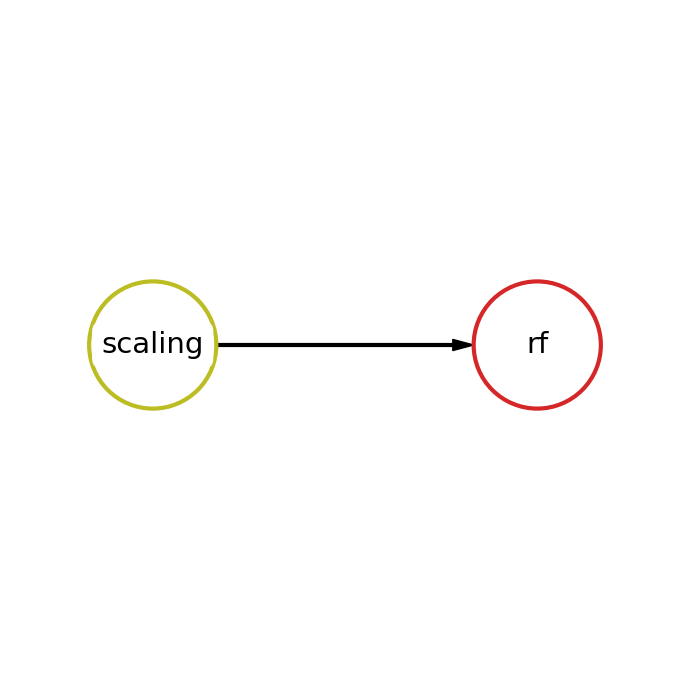

NameError: name 'test_dataset' is not defined

In [ ]:


#from data.data import get_train_data, get_test_data

#train_features, train_target = get_train_data()
#test_features, test_target = get_test_data()

# Task selection, initialisation of the framework
fedot_model = Fedot(problem='classification', timeout=3)

# Fit model
obtained_pipeline = fedot_model.fit(features=auto_X, target=auto_Y)
obtained_pipeline.show()


In [ ]:

# Make predictions
predict = fedot_model.predict(auto_X_test)
predict_probs = fedot_model.predict_proba(auto_X_test)

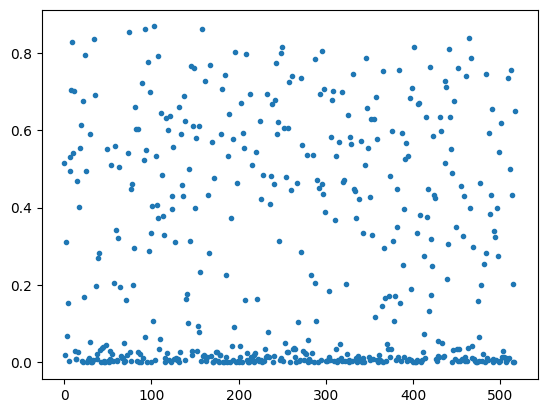

In [ ]:
plt.plot(predict_probs,'.')

In [ ]:
len(predict_probs)

518

In [ ]:
# Вычисляем F1-меру с помощью confusion matrix

# Порог отсечения - 0.5
for i in range(len(predict_probs)):
  if predict_probs[i] > 0.5:
    predict_probs[i] = 1
  else:
    predict_probs[i] = 0


cm = confusion_matrix(auto_Y_test, predict_probs)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

roc_auc = roc_auc_score(auto_Y_test, predict_probs)

print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

Confusion matrix: [[353  21]
 [ 25 119]]
F1-Score:  0.84
Accuracy: 0.91
Recall:  0.83
Precision:  0.85


## AutoML LightAutoML

https://github.com/sb-ai-lab/LightAutoML


In [ ]:
!pip install shap --quiet

In [ ]:
!pip install -U lightautoml --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.6/399.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.0/216.0 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 867.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:0

In [ ]:
# Импорт библиотек для auto ml
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized
from lightautoml.addons.tabular_interpretation import SSWARM

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import torch

import pandas as pd
import numpy as np

In [ ]:
N_THREADS = 4 #number of vCPUs for LightAutoML model creation
N_FOLDS = 3 # number of folds in LightAutoML inner CV
#All models that are trained during the cross-validation loop
#on different folds are then saved for the inference phase.
#Inference on new data is made by averaging models from all train folds.

RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 100 # Time in seconds for automl run
TARGET_NAME = 'Healthy_Status' # Target column name

In [ ]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [ ]:
train_data, test_data = train_test_split(
    autoML_df,
    test_size=TEST_SIZE,
    stratify=autoML_df[TARGET_NAME],
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

train_data.head()

Data is splitted. Parts sizes: train_data = (2758, 9), test_data = (690, 9)


rr_interval  p_end  qrs_onset  qrs_end  t_end  p_axis  qrs_axis  t_axis  \
1862          983    144        198      300    604      28        70      33   
3660          722    144        190      278    566      49        32      26   
498           645    108        206      288    584      68        64      60   
4130          576    160        184      266    502      64       -11      79   
1092          659    152        190      276    560      56        83      23   

      Healthy_Status  
1862               1  
3660               1  
498                1  
4130               0  
1092               1

In [ ]:
#The following task types are available:
#'binary' - for binary classification.
#'reg’ - for regression.
#‘multiclass’ - for multiclass classification.
#'multi:reg - for multiple regression.
#'multilabel' - for multi-label classification.

task = Task('binary')

You can also optionally specify the following roles:

'numeric' - numerical feature

'category' - categorical feature

'text' - text data

'datetime' - features with date and time

'date' - features with date only

'group' - features by which the data can be divided into groups and which can be taken into account for group k-fold validation (so the same group is not represented in both testing and training sets)

'drop' - features to drop, they will not be used in model building

'weights' - object weights for the loss and metric

'path' - image file paths (for CV tasks)

'treatment' - object group in uplift modelling tasks: treatment or control

In [ ]:
roles = {
    'target': TARGET_NAME
    #'category': TARGET_NAME
    #'drop': ['name of column']
}

In [ ]:
automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

In [ ]:
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 0)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
test_predictions = automl.predict(test_data).data
#print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')
#plt.plot(test_predictions.data[:],'.')

In [ ]:
test_data.head()

rr_interval  p_end  qrs_onset  qrs_end  t_end  p_axis  qrs_axis  t_axis  \
3795          821    160        230      322    658      75        84      76   
2503          923    150        220      316    620      17       -17      21   
258           895    140        194      272    584      59       -30      41   
2411          845    104        210      382    676       2       -63      97   
4894          618    130        150      220    470      -5       -22      29   

      Healthy_Status  
3795               0  
2503               0  
258                0  
2411               0  
4894               1

In [ ]:
# Порог отсечения - 0.5
for i in range(len(test_predictions)):
  if test_predictions[i] > 0.5:
    test_predictions[i] = 1
  else:
    test_predictions[i] = 0

# Вычисляем F1-меру с помощью confusion matrix
cm = confusion_matrix(test_data['Healthy_Status'], test_predictions)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

Confusion matrix: [[457  41]
 [ 85 107]]
F1-Score:  0.63
Accuracy: 0.82
Recall:  0.56
Precision:  0.72


In [ ]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.76393 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.23607 * (3 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


In [ ]:
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task,
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [ ]:
out_of_fold_predictions = automl_rd.fit_predict(train_data, roles = roles, verbose = 1)

In [ ]:
!ls tabularAutoML_model_report

feature_importance.png		  valid_pie_f1_metric.png		valid_roc_curve.png
lama_interactive_report.html	  valid_pr_curve.png
valid_distribution_of_logits.png  valid_preds_distribution_by_bins.png


CPU times: user 68.2 ms, sys: 19.7 ms, total: 87.9 ms
Wall time: 72.7 ms


<Axes: xlabel='Feature'>

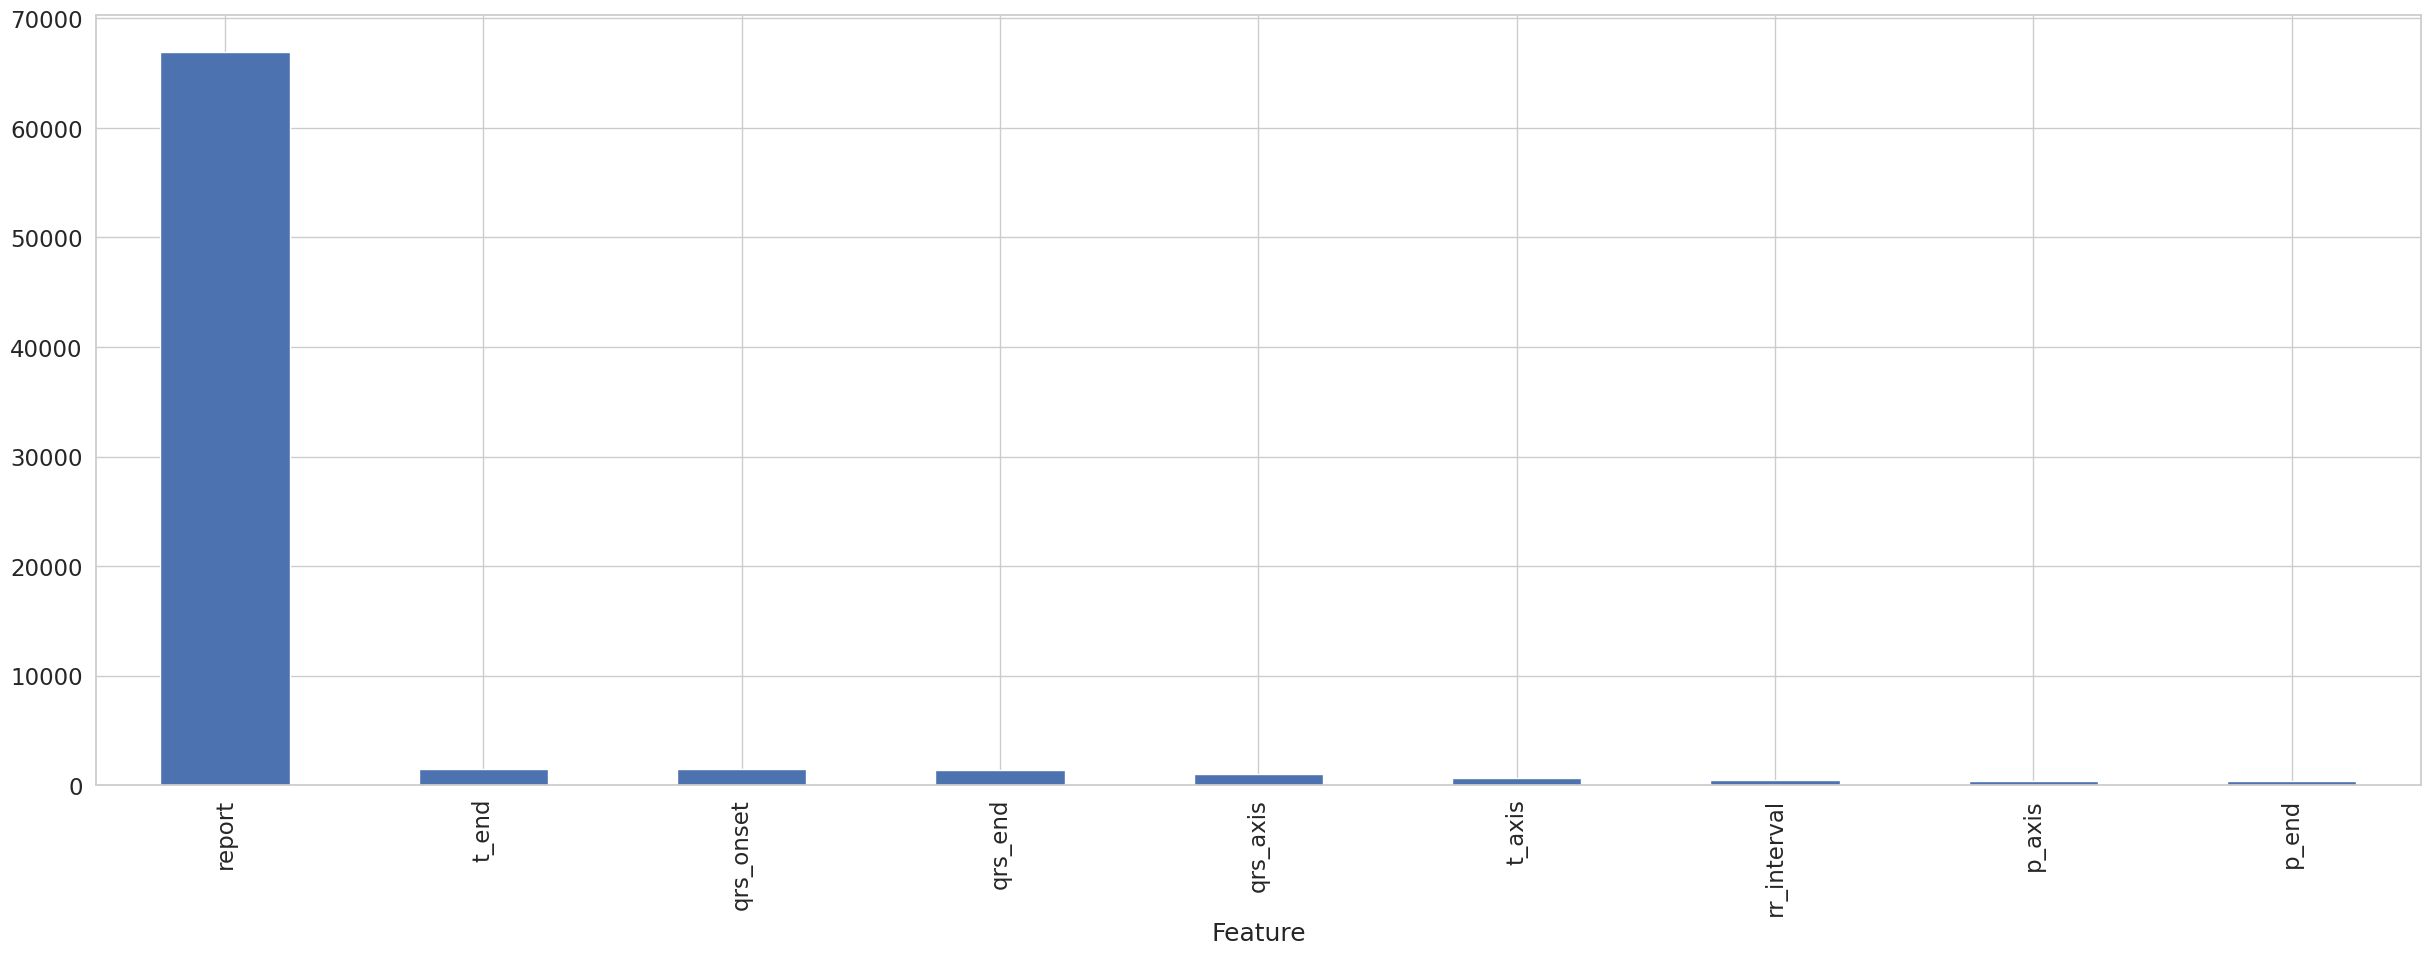

In [ ]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

CPU times: user 5.01 s, sys: 252 ms, total: 5.27 s
Wall time: 8.72 s


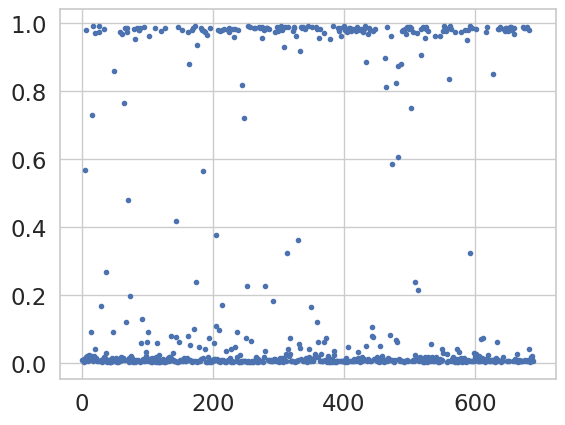

In [ ]:
%%time
test_predictions = automl_rd.predict(test_data)
#print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')
plt.plot(test_predictions.data[:],'.')

In [ ]:
#print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, out_of_fold_predictions.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(test_data[TARGET_NAME].values, test_predictions.data[:, 0])}')

HOLDOUT score: 0.9993724899598393


In [ ]:
explainer = SSWARM(automl_rd.model)
shap_values = explainer.shap_values(test_data, n_jobs=N_THREADS)

100%|██████████| 1500/1500 [01:38<00:00, 15.28it/s]


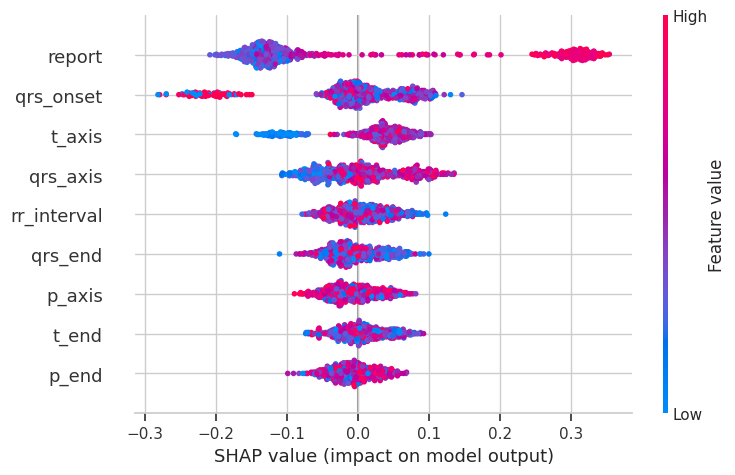

In [ ]:
# summary plot
import shap
shap.summary_plot(shap_values[1], test_data[explainer.used_feats])

In [ ]:
train_data.head()

report  rr_interval  p_end  qrs_onset  qrs_end  t_end  p_axis  \
1862  0.016385          983    144        198      300    604      28   
3660  0.023945          722    144        190      278    566      49   
498   0.023945          645    108        206      288    584      68   
4130  0.014724          576    160        184      266    502      64   
1092  0.023945          659    152        190      276    560      56   

      qrs_axis  t_axis  Healthy_Status  
1862        70      33               1  
3660        32      26               1  
498         64      60               1  
4130       -11      79               0  
1092        83      23               1

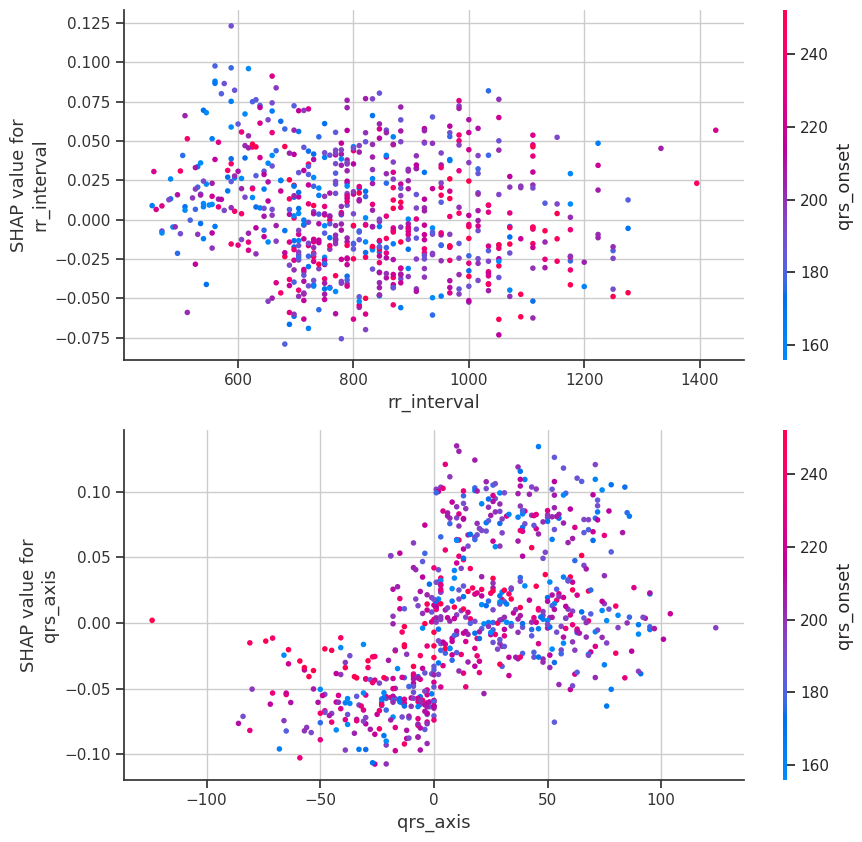

In [ ]:
# dependence plots
import matplotlib.pyplot as plt

feats = ["rr_interval", "qrs_axis"]
fig, ax = plt.subplots(nrows=len(feats), ncols=1, figsize=(10, 5*len(feats)))

for i, feat in enumerate(feats):
    shap.dependence_plot(feat, shap_values[1], test_data[explainer.used_feats],
                         show=False, ax=ax[i], interaction_index="qrs_onset")

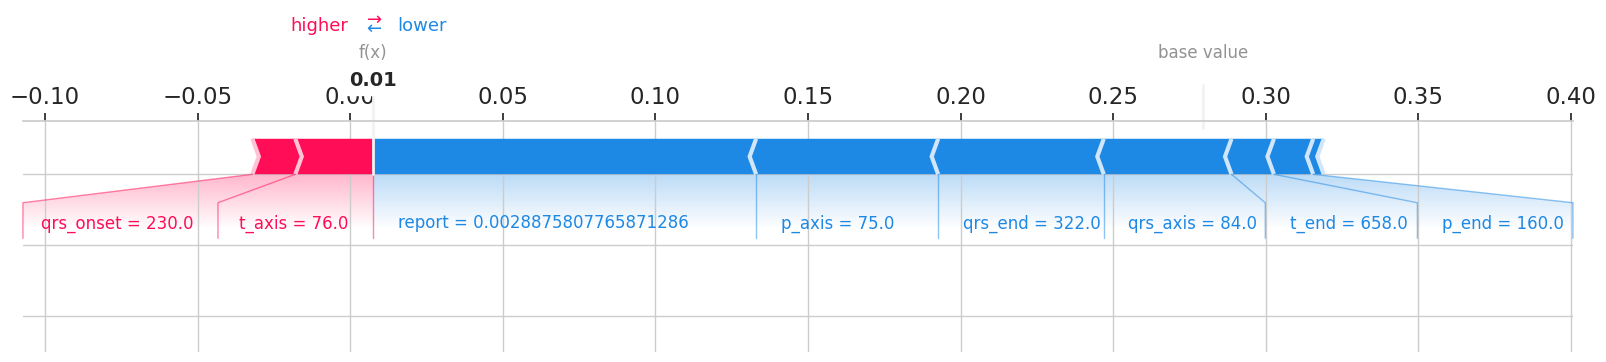

In [ ]:
# individual force plot
shap.force_plot(explainer.expected_value[1], shap_values[1][0], test_data[explainer.used_feats].iloc[0], matplotlib=True)


## AutoML GAMA

https://openml-labs.github.io/gama/master/

In [ ]:
!pip install s

In [ ]:
!pip install gama --quiet

In [ ]:
from sklearn.metrics import log_loss, accuracy_score
from gama import GamaClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [ ]:
Y_auto = autoML_df['Healthy_Status'] # таргет
X_auto = autoML_df.iloc[:, :8] # переменные

# Разбиваем данные на обучающую и тестовую выборки
RANDOM_SEED = 0

X_train, X_test, y_train, y_test = train_test_split(X_auto, Y_auto, train_size=0.70, random_state=RANDOM_SEED, stratify=Y_auto)
print('Распределение Y_train по классам 0 и 1 соответственно:', np.bincount(y_train))
print('Распределение Y_test по классам 0 и 1 соответственно:', np.bincount(y_test))

Распределение Y_train по классам 0 и 1 соответственно: [1741  672]
Распределение Y_test по классам 0 и 1 соответственно: [747 288]


In [ ]:
automl = GamaClassifier(max_total_time=60, store="nothing")
print("Starting `fit` which will take roughly 1 minutes.")
automl.fit(X_train, y_train)

DEBUG:gama:Removing StreamHandlers registered by previous GAMA instance(s).
INFO:gama.gama:Using GAMA version 23.0.0.post1.
INFO:gama.gama:INIT:GamaClassifier(search_space={'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False], 'min_samples_split': range(2, 21), 'min_samples_leaf': range(1, 21), <class 'sklearn.naive_bayes.GaussianNB'>: {}, <class 'sklearn.naive_bayes.BernoulliNB'>: {'alpha': [], 'fit_prior': []}, <class 'sklearn.naive_bayes.MultinomialNB'>: {'alpha': [], 'fit_prior': []}, <class 'sklearn.tree._classes.DecisionTreeClassifier'>: {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 11), 'min_samples_split': [], 'min_samples_leaf': []}, <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>: {'n_estimators': [100], 'criterion': ['gini', 'entropy'], 'max_features': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), 'min_samples_split': [], 'min_samples_leaf': [], '

Starting `fit` which will take roughly 1 minutes.


INFO:gama.search_methods.async_ea:Starting EA with new population.
DEBUG:gama.utilities.generic.async_evaluator:Signaling 1 subprocesses to stop.
INFO:gama.gama:Search phase evaluated 45 individuals.
INFO:gama.utilities.generic.timekeeper:STOP: search AsyncEA after 53.0650s.
INFO:gama.utilities.generic.timekeeper:START: postprocess BestFitPostProcessing
INFO:gama.utilities.generic.timekeeper:STOP: postprocess BestFitPostProcessing after 0.6998s.


In [ ]:
label_predictions = automl.predict(X_test)
probability_predictions = automl.predict_proba(X_test)

print('accuracy:', accuracy_score(y_test, label_predictions))
print('log loss:', log_loss(y_test, probability_predictions))
# the `score` function outputs the score on the metric optimized towards (by default, `log_loss`)
print('log_loss', automl.score(X_test, y_test))

accuracy: 0.9777777777777777
log loss: 0.08609400351663057
log_loss 0.08609400351663057


In [ ]:
test_preds = label_predictions.data

# Порог отсечения - 0.5
for i in range(len(test_preds)):
  if test_preds[i] > 0.5:
    test_preds[i] = 1
  else:
    test_preds[i] = 0

# Вычисляем F1-меру с помощью confusion matrix
cm = confusion_matrix(y_test, test_preds)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

Confusion matrix: [[645 102]
 [119 169]]
F1-Score:  0.60
Accuracy: 0.79
Recall:  0.59
Precision:  0.62


## AutoML PyCaret

https://habr.com/ru/companies/ods/articles/657525/

In [ ]:
!pip install pycaret --quiet

In [ ]:
#from pycaret.datasets import get_data

#  Набор данных о неплательщиках по кредиту
df = autoML_df

# Проверка формы набора данных
print('исходный набор данных: ',df.shape)

# Инициализация начального числа для генераторов случайных чисел
seed = 17

# Создание обучающего набора с помощью выборки pandas — видимый набор данных
train_data = df.sample(frac=.8, random_state=seed)
#knowledge.reset_index(inplace=True, drop=True)
print('выделяем из исходного набора данныз базу для обучения: ', train_data.shape)

# Использование образцов, недоступных в обучающем наборе, в качестве будущего или невидимого набора данных
test_data = df.drop(train_data.index)
#payload.reset_index(inplace=True, drop=True)
print('набор данных для проверки: ',test_data.shape)


исходный набор данных:  (3448, 10)
выделяем из исходного набора данныз базу для обучения:  (2758, 10)
набор данных для проверки:  (690, 10)


In [ ]:
# Задействуем волшебную функцию!
from pycaret.classification import *

# Функция setup инициализирует среду и создает конвейер преобразования
clf = setup(data=autoML_df, target="Healthy_Status", session_id=123)

Processing:   0%|          | 0/69 [00:00<?, ?it/s]

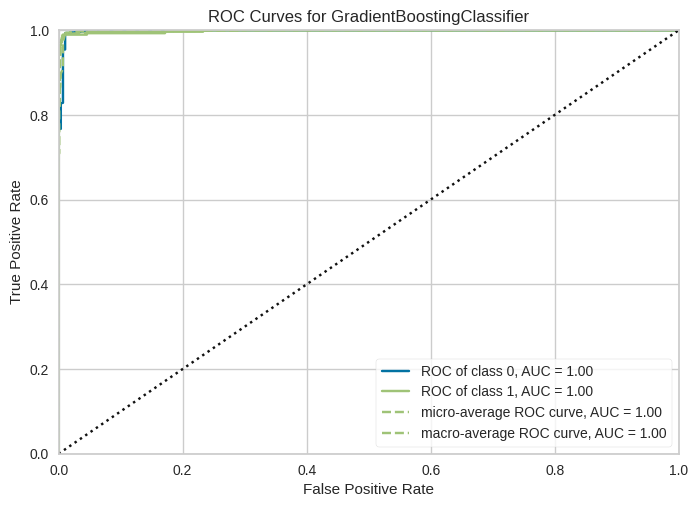

In [ ]:
# Сравниваем различные модели в зависимости от их метрик производительности. По умолчанию модели сортируются по точности
best_model = compare_models(fold=5)

# Построение кривой AUC
plot_model(best_model, plot="auc")

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


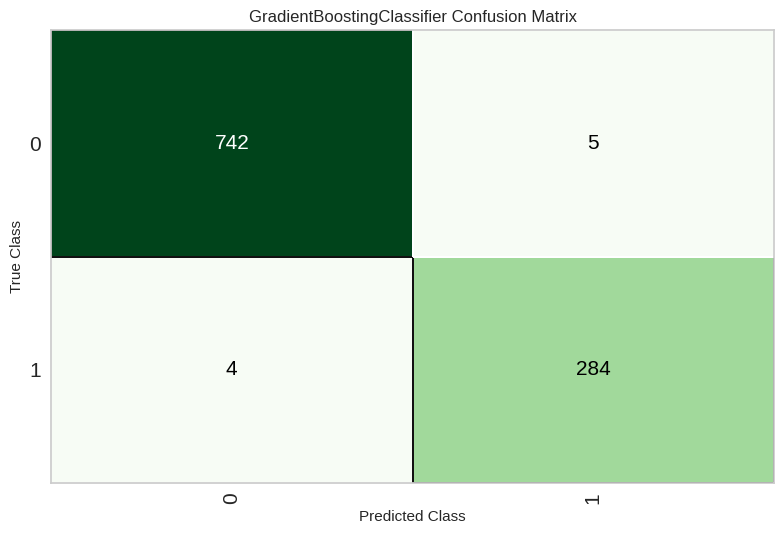

In [ ]:
# Функция Tune model выполняет сеточный поиск для определения оптимальных параметров
tuned = tune_model(best_model)
plot_model(tuned, plot="confusion_matrix")

# Прогнозирование на тестовом наборе
predict_model(tuned)

# Доработка модели путем переобучения на всем видимом наборе данных
final_model = finalize_model(tuned)

In [ ]:
# Прогнозирование на тестовом наборе
predict_model(tuned)

# Доработка модели путем переобучения на всем видимом наборе данных
final_model = finalize_model(tuned)

# Прогнозирование на невидимых данных
predictions = predict_model(final_model, data=test_data)
predictions.head()

report  rr_interval  p_end  qrs_onset  qrs_end  t_end  p_axis  qrs_axis  \
1   0.012426          722    124        162      246    504      77        75   
15  0.002052          487    132        234      312    586      81        36   
25 -0.005798          722    150        226      310    612      26         3   
27 -0.002328          722    156        176      272    564      47        52   
34 -0.010655          882    180        210      292    650      32       -26   

    t_axis  Healthy_Status  prediction_label  prediction_score  
1       70               0                 0            0.9727  
15      97               0                 0            0.9977  
25      11               0                 0            0.9982  
27      46               0                 0            0.9966  
34     -90               0                 0            0.9990

# ML GaussianNaiveBayes

In [ ]:
class GaussianNaiveBayes:
    def fit(self, X, y):
        classes, cls_counts = np.unique(y, return_counts=True)
        n_classes = len(classes)
        self.priors = cls_counts / len(y)

        # calculate the mean and standard deviations of features by classes
        self.X_cls_mean = np.array([np.mean(X[y == c], axis=0) for c in range(n_classes)])
        self.X_stds = np.array([np.std(X[y == c], axis=0) for c in range(n_classes)])

    # calculate the probability density of the feature according to the Gaussian distribution
    def pdf(self, x, mean, std):
        return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

    def predict(self, X):
        pdfs = np.array([self.pdf(x, self.X_cls_mean, self.X_stds) for x in X])
        posteriors = self.priors * np.prod(pdfs, axis=2)   # shorten Bayes formula

        return np.argmax(posteriors, axis=1)

In [ ]:
#So, when you do [:, -1] it means you are taking all the rows and only the last column. -1 represents the last column.
#When you do [:, :-1], it means you are taking all the rows and all the columns except the last column.
#X1, y1 = table_data.iloc[:, :-1], table_data.iloc[:, -1]

In [ ]:
# set the classification index of table
clf_index = 0

# classification variable
y1 = table_data.iloc[:, clf_index]
# input variable
X1 = table_data.drop(table_data.columns[[clf_index]], axis=1).iloc[:,:]

y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1.values,
                                                        y1.values,
                                                        test_size=0.3,
                                                        random_state=0,
                                                        stratify=y1.values)

In [ ]:
nb_clf = GaussianNaiveBayes()
nb_clf.fit(X1_train, y1_train)
nb_clf_pred_res = nb_clf.predict(X1_test)
nb_clf_accuracy = accuracy_score(y1_test, nb_clf_pred_res)

print(f'Naive Bayes classifier accucacy: {nb_clf_accuracy}')
print(nb_clf_pred_res)

Naive Bayes classifier accucacy: 0.29347198151357595
[1 1 1 ... 1 1 1]


<ipython-input-65-e61f33113988>:13: RuntimeWarning: divide by zero encountered in divide
  return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
<ipython-input-65-e61f33113988>:13: RuntimeWarning: invalid value encountered in divide
  return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)


sk Naive Bayes classifier accucacy: 0.4119006354708261
[1 0 0 ... 1 1 1]


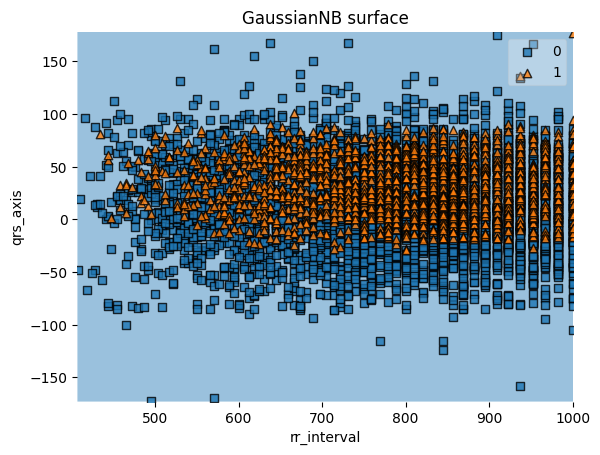

In [ ]:
sk_nb_clf = GaussianNB()
sk_nb_clf.fit(X1_train, y1_train)
sk_nb_clf_pred_res = sk_nb_clf.predict(X1_test)
sk_nb_clf_accuracy = accuracy_score(y1_test, sk_nb_clf_pred_res)

print(f'sk Naive Bayes classifier accucacy: {sk_nb_clf_accuracy}')
print(sk_nb_clf_pred_res)

feature_indexes = [0, 6]
title1 = 'GaussianNB surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, sk_nb_clf, feature_indexes, title1)

# MDS

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS

Text(0, 0.5, 'Second Principal Component')

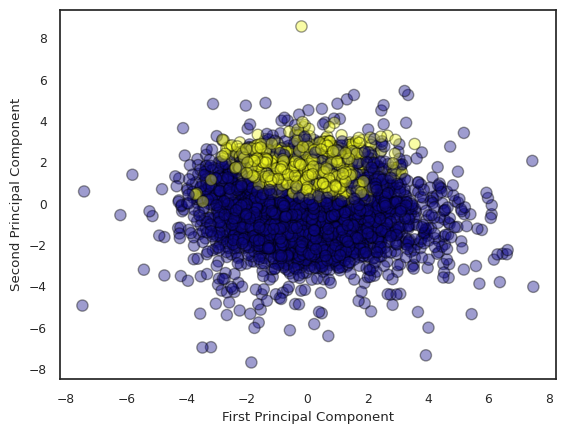

In [ ]:
mds = MDS(n_components = 2)
scaled_data_mds = mds.fit_transform(scaled_data)

plt.scatter(scaled_data_mds[:,0], scaled_data_mds[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

Text(0, 0.5, 'Second Principal Component')

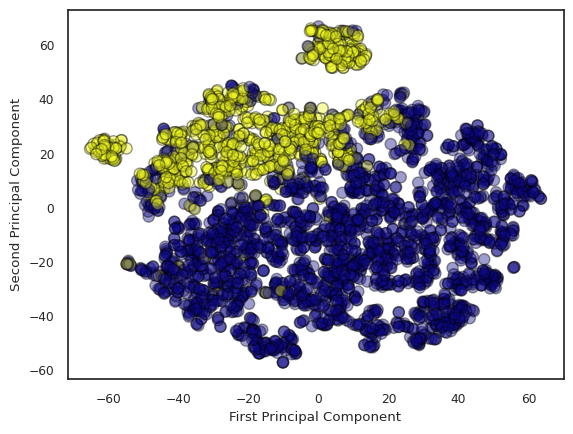

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
scaled_data_mds_tsne = tsne.fit_transform(scaled_data)
plt.scatter(scaled_data_mds_tsne[:,0], scaled_data_mds_tsne[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import ward, dendrogram, fcluster

In [ ]:

#scaled_data, data_table['Healthy_status'] = make_blobs(random_state = 10)
# n_clusters must be None if distance_threshold is not None
cls = AgglomerativeClustering(n_clusters = 5, affinity='euclidean',linkage='ward', distance_threshold=None)
cls_assignment = cls.fit_predict(scaled_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


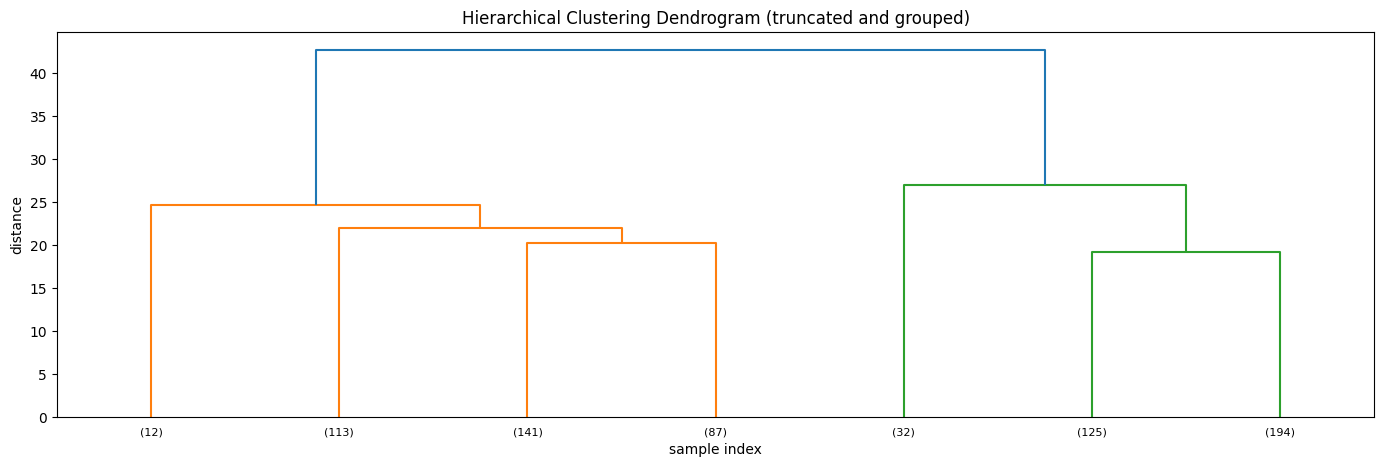

In [ ]:
Z = ward(scaled_data)
plt.figure(figsize=(17,5));
R = dendrogram(Z, truncate_mode='lastp', p=7, orientation='top', leaf_font_size=8)
plt.title('Hierarchical Clustering Dendrogram (truncated and grouped)')
plt.xlabel('sample index')
plt.ylabel('distance')
plt.show()

https://stackoverflow.com/questions/54810800/how-to-get-a-list-of-all-leaves-under-a-node-in-a-dendrogram

In [ ]:
# put X in a dataframe
df = pd.DataFrame()
df['col1']=X[:,0]
df['col2']=X[:,1]

index=[]
for i in range(len(X)):
    elem = 'A' + str(i)
    index.append(elem)

df['index'] = index
print(df.shape)
df.head()

# retrieve elements in each cluster
label = fcluster(Z, 5, criterion='maxclust')

df_clst = pd.DataFrame()
df_clst['index']  = df['index']
df_clst['label']  = label

# print them
for i in range(5):
   elements = df_clst[df_clst['label']==i+1]['index'].tolist()
   size = len(elements)
   print('\n Cluster {}: N = {}  {}'.format(i+1, size, elements))

NameError: name 'fcluster' is not defined

In [ ]:
from scipy.cluster.hierarchy import fcluster
fl = fcluster(Z,5,criterion='maxclust')

In [ ]:
R

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [13.75, 13.75, 52.5, 52.5]],
 'dcoord': [[0.0, 20.250716396171867, 20.250716396171867, 0.0],
  [0.0, 22.006139199097237, 22.006139199097237, 20.250716396171867],
  [0.0, 24.635641196702398, 24.635641196702398, 22.006139199097237],
  [0.0, 19.146048741900454, 19.146048741900454, 0.0],
  [0.0, 27.017808675252834, 27.017808675252834, 19.146048741900454],
  [24.635641196702398,
   42.71244083393276,
   42.71244083393276,
   27.017808675252834]],
 'ivl': ['(12)', '(113)', '(141)', '(87)', '(32)', '(125)', '(194)'],
 'leaves': [1379, 1391, 1398, 1400, 1389, 1396, 1399],
 'color_list': ['C1', 'C1', 'C1', 'C2', 'C2', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2']}

In [ ]:
R

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [13.75, 13.75, 52.5, 52.5]],
 'dcoord': [[0.0, 20.250716396171867, 20.250716396171867, 0.0],
  [0.0, 22.006139199097237, 22.006139199097237, 20.250716396171867],
  [0.0, 24.635641196702398, 24.635641196702398, 22.006139199097237],
  [0.0, 19.146048741900454, 19.146048741900454, 0.0],
  [0.0, 27.017808675252834, 27.017808675252834, 19.146048741900454],
  [24.635641196702398,
   42.71244083393276,
   42.71244083393276,
   27.017808675252834]],
 'ivl': ['(12)', '(113)', '(141)', '(87)', '(32)', '(125)', '(194)'],
 'leaves': [1379, 1391, 1398, 1400, 1389, 1396, 1399],
 'color_list': ['C1', 'C1', 'C1', 'C2', 'C2', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2']}

In [ ]:
import scipy.cluster.hierarchy as sch

In [ ]:
linkage_matrix = sch.average(scaled_data)
rootnode, nodelist = sch.to_tree(linkage_matrix, rd=True)
leaves = sch.leaves_list(linkage_matrix)
print(linkage_matrix[3,:])
#sch.dendrogram(linkage_matrix);

[6.48000000e+02 6.49000000e+02 1.62090411e-01 2.00000000e+00]


In [ ]:
R

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [13.75, 13.75, 52.5, 52.5]],
 'dcoord': [[0.0, 20.250716396171867, 20.250716396171867, 0.0],
  [0.0, 22.006139199097237, 22.006139199097237, 20.250716396171867],
  [0.0, 24.635641196702398, 24.635641196702398, 22.006139199097237],
  [0.0, 19.146048741900454, 19.146048741900454, 0.0],
  [0.0, 27.017808675252834, 27.017808675252834, 19.146048741900454],
  [24.635641196702398,
   42.71244083393276,
   42.71244083393276,
   27.017808675252834]],
 'ivl': ['(12)', '(113)', '(141)', '(87)', '(32)', '(125)', '(194)'],
 'leaves': [1379, 1391, 1398, 1400, 1389, 1396, 1399],
 'color_list': ['C1', 'C1', 'C1', 'C2', 'C2', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2']}

# Affinity propagation

In [ ]:
from sklearn import metrics
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import adjusted_rand_score

In [ ]:
def plot_connected_points(X, labels, centers, cmap):
    for i in range(len(X)):
        color = cmap(labels[i] / len(centers))
        plt.plot([X[i, 0], centers[labels[i], 0]], [X[i, 1], centers[labels[i], 1]], c=color, alpha=0.8)

In [ ]:
sk_ap = AffinityPropagation()
sk_ap_pred_res = sk_ap.fit_predict(scaled_data)
sk_ap_ari = adjusted_rand_score(table_data['Healthy_Status'], sk_ap_pred_res)
print(f'Adjusted Rand Score for sk AffinityPropagation: {sk_ap_ari}', '', sep='\n')
print('Number of clusters = ', np.max(sk_ap_pred_res))
#print('prediction', sk_ap_pred_res, sep='\n')

Adjusted Rand Score for sk AffinityPropagation: 0.0032783107337274802

Number of clusters =  50


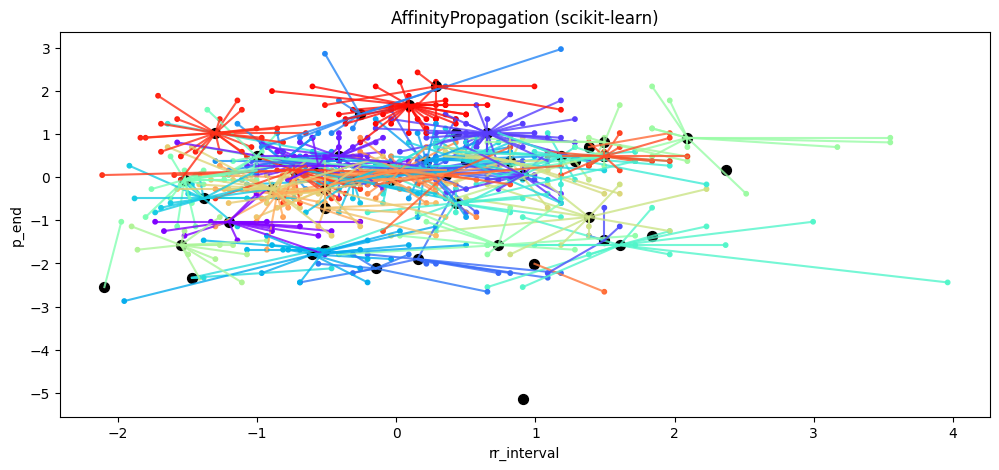

In [ ]:
plt.figure(figsize=(12, 5))

plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=sk_ap_pred_res, cmap='rainbow', s=10)
plt.scatter(sk_ap.cluster_centers_[:, 0], sk_ap.cluster_centers_[:, 1], c='black', s=50)
plt.title('AffinityPropagation (scikit-learn)')
plt.xlabel(table_data.columns[1])
plt.ylabel(table_data.columns[2])

plot_connected_points(scaled_data, sk_ap_pred_res, sk_ap.cluster_centers_, plt.cm.rainbow)

plt.show()

# Agglomerative Clustering

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    #plt.figure(figsize=(17,5));
    dendrogram(linkage_matrix, **kwargs)
    plt.rcParams["figure.figsize"] = (17,5)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()



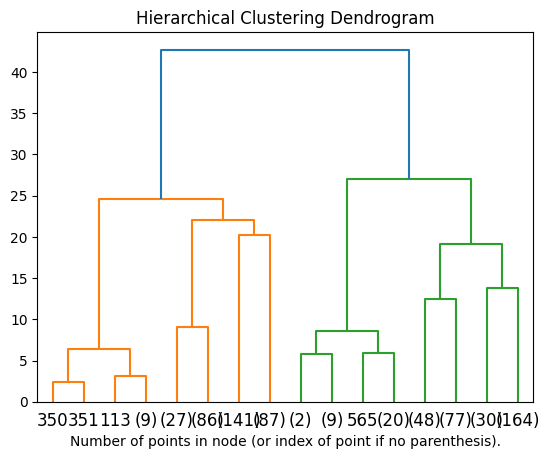

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(scaled_data)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
#

# Сравнение ML алгоритмов

In [ ]:
table_data.columns

Index(['Healthy_Status', 'rr_interval', 'p_onset', 'p_end', 'qrs_onset',
       'qrs_end', 'p_axis', 'qrs_axis'],
      dtype='object')

In [ ]:
clf_index = 0
feature_indexes = [4, 7]

table_data_clf = (table_data.values[:,feature_indexes],
                  table_data[table_data.columns[clf_index]])

In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

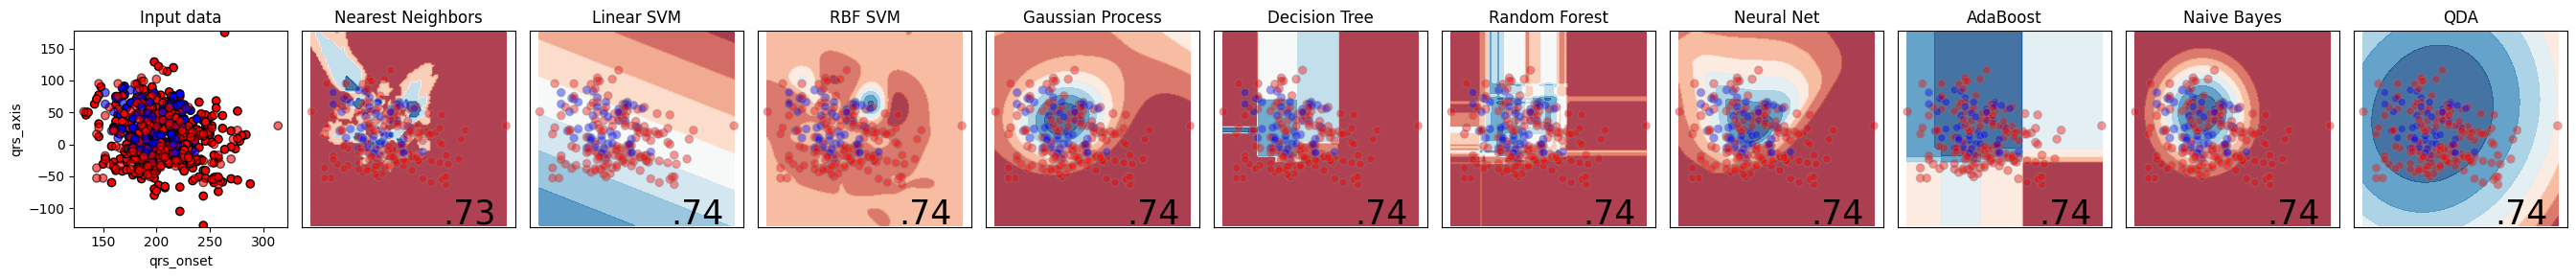

In [ ]:

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]


datasets = [
    #make_moons(noise=0.3, random_state=0),
    #make_circles(noise=0.2, factor=0.5, random_state=1),
    #linearly_separable,
    table_data_clf
]

figure = plt.figure(figsize=(27, 3))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    #x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    #y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    x_range = abs(X[:, 0].max()) - abs(X[:, 0].min())
    y_range = abs(X[:, 1].max()) - abs(X[:, 1].min())

    x_min, x_max = X[:, 0].min() - 0.05*x_range, X[:, 0].max() + 0.05*x_range
    y_min, y_max = X[:, 1].min() - 0.05*y_range, X[:, 1].max() + 0.05*y_range


    # just plot the dataset first
    cm = plt.cm.RdBu
    # red and blue = 0000FF color. Red = 0. Blue = 1 status
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    #ax.set_xticks(())
    #ax.set_yticks(())
    ax.set_xlabel(table_data.columns[feature_indexes[0]])
    ax.set_ylabel(table_data.columns[feature_indexes[1]])
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        #ax.scatter(
        #    X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        #)
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="grey",
            alpha=0.4,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - x_range*0.1,
            y_min + y_range*0.1,
            ("%.2f" % score).lstrip("0"),
            size=25,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

In [ ]:
datasets

[(array([[ 0, 81],
         [ 0, 77],
         [ 1, 79],
         ...,
         [ 1, 70],
         [ 1, 43],
         [ 0, 30]]),
  0       0
  1       0
  2       1
  3       1
  6       1
         ..
  9994    1
  9995    1
  9996    1
  9998    1
  9999    0
  Name: Healthy_Status, Length: 7046, dtype: int64)]

# Примеры классификаторов на модельных задачах

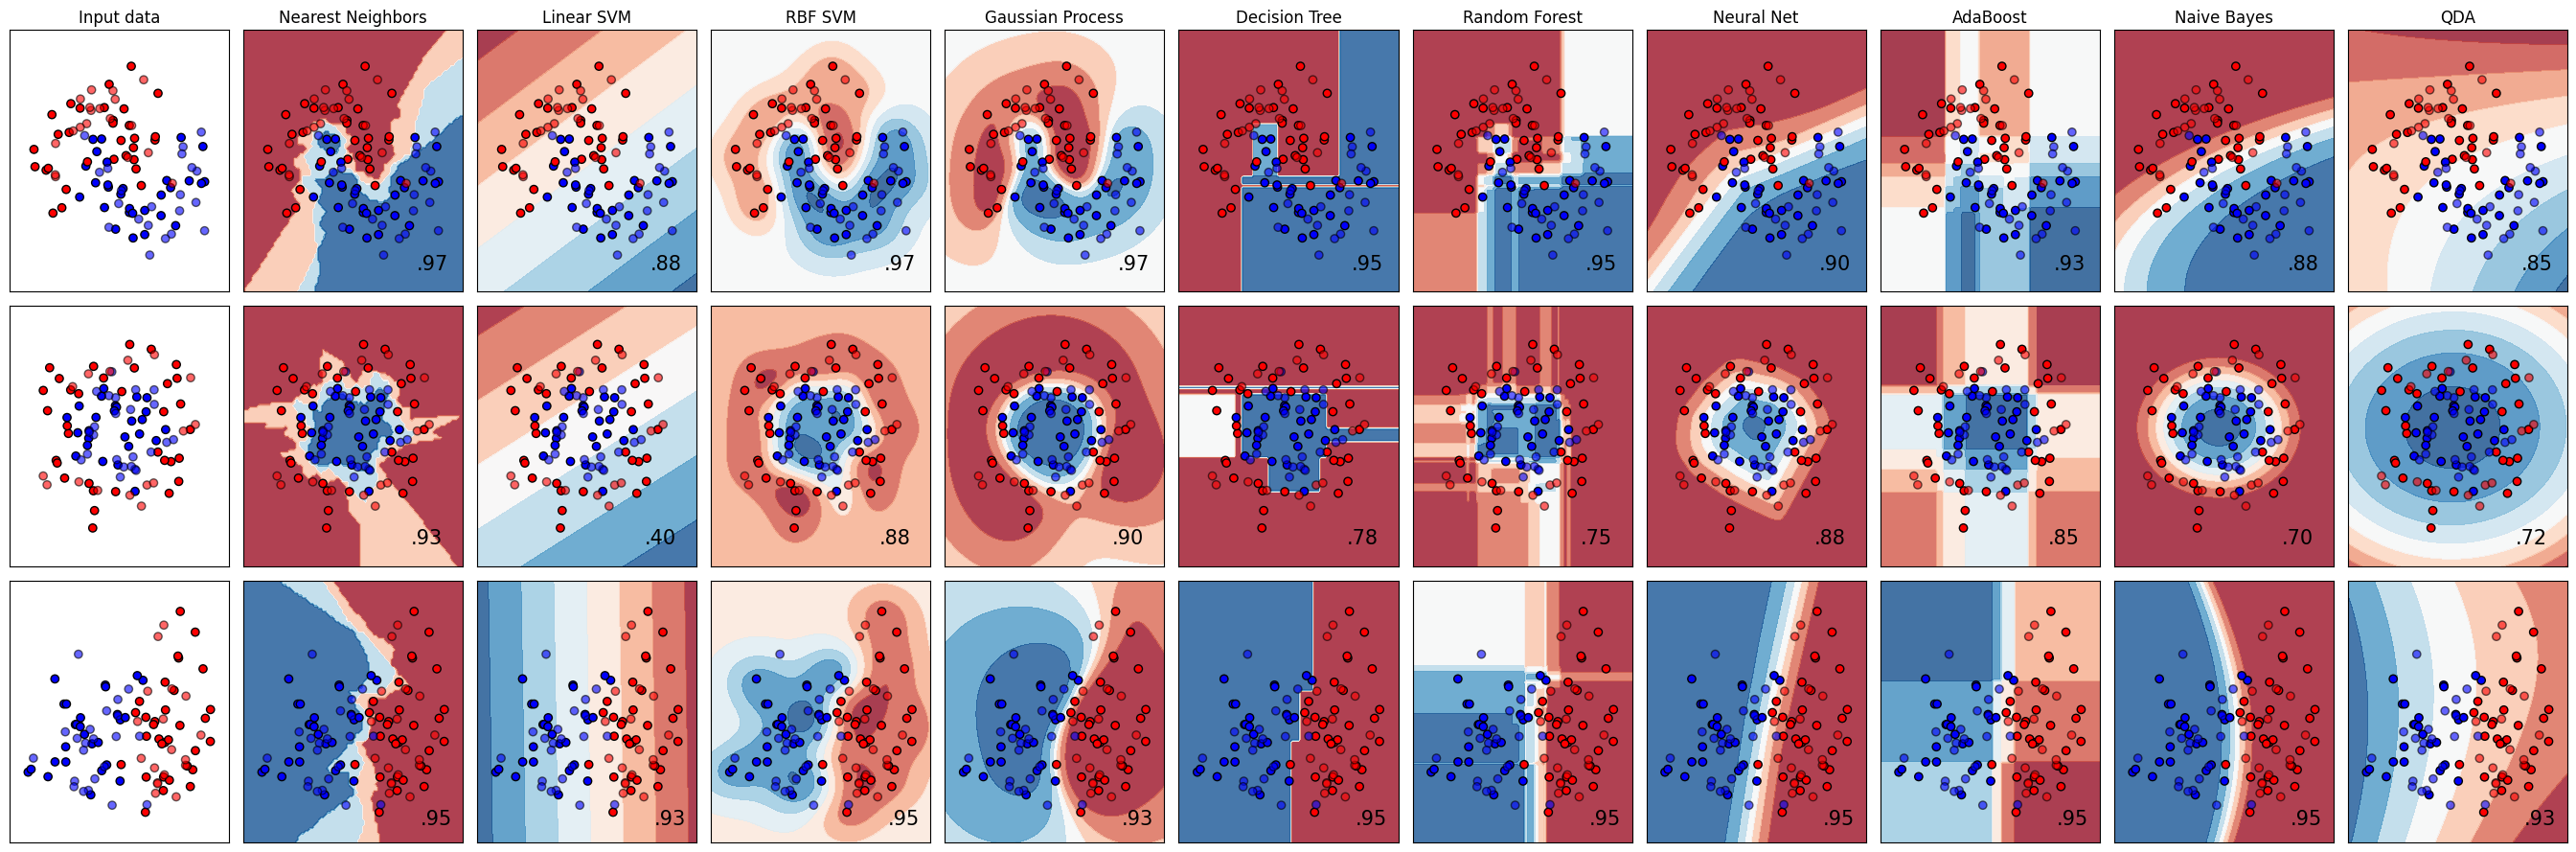

In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    # red and blue = 0000FF color. Red = 0, Blue = 1 status
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()